# Extrapolate LCs at early times

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import emcee
import scipy.optimize as opt

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [7]:
import os
COCO_PATH=os.environ['COCO_PATH']
DATALC_PATH = COCO_PATH+"/Inputs/Photometry/2_LCs_dust_corr/"
DATASPEC_PATH = COCO_PATH+"/Inputs/Spectroscopy/2_LCs_dust_corr/"

DATAINFO_PATH= COCO_PATH+"Inputs/SNe_Info/"
FILTER_PATH = COCO_PATH+"Inputs/Filters/"

OUTPUT_PATH = COCO_PATH+"/Inputs/Photometry/3_LCs_early_extrapolation/"

import sys
sys.path.insert(0, COCO_PATH+'what_the_flux/')
import what_the_flux as wtf

In [11]:
info_objects = pd.read_csv(DATAINFO_PATH+'info.dat', comment='#', delimiter=' ')
name_type = dict(zip(info_objects['Name'], info_objects['Type']))

In [13]:
se_sne = [row.Name for i,row in info_objects.iterrows() if row.Type in ['IIb', 'Ib', 'Ic', 'Ic-BL', 'Ibc-pec']]
hydr_sne = [row.Name for i,row in info_objects.iterrows() if row.Type in ['IIn', 'II', 'IIL', 'IIP', '1987A', '87A']]

In [14]:
color_dict = {'Bessell_U': 'blue', 'Bessell_B': 'royalblue','Bessell_V':  'limegreen',
              'Bessell_R':  'red', 'Bessell_I':  'mediumvioletred',
              'sdss_g':'darkgreen','ptf_g':'darkgreen', "sdss_g'":'darkgreen','sdss_i':'indianred',
              "sdss_i'":'indianred','sdss_r': 'darkred', "sdss_r'":'darkred','sdss_z':'sienna', "sdss_z'":'sienna',
              'sdss_u': 'darkblue', "sdss_u'": 'darkblue', 'Y':'salmon','H':'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown', 'swift_UVW1':'indigo', 'swift_UVW2':'darkblue',
               'swift_UVM2':'darkmagenta','swift_U':'plum','swift_V':'teal','swift_B':'powderblue'}

exclude_filt = ['H', 'J', 'K', 'Ks','KS', 'Y']

In [15]:
def err_to_log10(flux, err_flux):
    flux=np.array(flux, dtype=float)
    err_flux=np.array(err_flux, dtype=float)
    return 1./np.log(10.) * err_flux/flux

def err_from_log10(logflux, logerr_flux):
    return np.log(10.) * 10**logflux * logerr_flux

## linear regression from x,y independent errors
def lin_regr_weigthed(x,y,w):
    Delta = sum(w)*sum(w*x**2) - (sum(w*x))**2
    A = ( sum(w*x**2)*sum(w*y) - sum(w*x)*sum(w*y*x) )/(Delta)
    B = ( sum(w)*sum(w*y*x) - sum(w*x)*sum(w*y) )/(Delta)
    print (A,B)
    sigma_A = np.sqrt( sum(w*x**2)/Delta )
    sigma_B = np.sqrt( sum(w)/Delta )
    print (sigma_A,sigma_B)
    return (A,B,sigma_A,sigma_B)

def rise_func(x, a, t0, n):
    f_t = np.zeros(len(x))
    f_t[x>t0] = a * (x[x>t0]-t0)**1.5
    return f_t

In [16]:

class SNPhotometryClass():
    """Class with photometry for each object:
            - load the photometry from the DATA folder
            - get the phootmetry in each filter
            - plot the raw photometry 
            - fit the photometry using GP
    """
    
    def __init__(self, main_path, lc_path, snname, verbose=False):
        """
        """

        ## Initialise the class variables
        self.main_path = main_path
        self.lc_data_path = lc_path+'/'
        #self.lc_data_path = '/Users/mariavincenzi/PhD/pycoco_2/data/lc/'

        self.spec_data_path = main_path+'/spec/'
        self.snname = snname   
        self.set_data_directory(verbose)

    def set_data_directory(self, verbose):
        """
        Set a new data directory path.
        Enables the data directory to be changed by the user.
        """
        SNphotometry_PATH = os.path.join(self.lc_data_path, '%s.dat'%self.snname)
        
        try:
            if verbose: print('Looking for Photometry for %s in%s'%(self.snname, SNphotometry_PATH))
            if os.path.isfile(SNphotometry_PATH):
                if verbose: print ('Got it!')
                self.sn_rawphot_file = SNphotometry_PATH
                pass
            else:
                if not os.path.isdir(self.lc_data_path):
                    print ('I cant find the directory with photometry. Check %s'%self.lc_data_path)
                    pass
                else: 
                    print ('I cant find the file with photometry. Check %s'%SNphotometry_PATH)
                    pass
    
        except Exception as e:
            print (e)

    def load(self, verbose = False):
        """
        Loads a single photometry file.
        with ('MJD', 'Flux', 'Flux_err', 'band')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        if verbose: print('Loading %s'%self.sn_rawphot_file)
        try:
            lc_file = pd.read_csv(self.sn_rawphot_file,
                                    dtype=None,encoding="utf-8")

            mask_filt = np.array([f not in exclude_filt for f in lc_file['band']])
            lc_no_badfilters = lc_file[mask_filt]
            mask_filt = np.array([~np.isnan(f) for f in lc_no_badfilters['Flux']])
            self.phot = lc_no_badfilters[mask_filt]
            
            #filtname_filtset = [fn+'__'+fs for fn,fs in zip(self.phot['band'], self.phot['FilterSet'])]
            self.avail_filters = np.unique(self.phot['band'])

            self.phot_extended = self.phot
            print ('Photometry loaded')

        except Exception as e:
            print (e)
            print ('Are you sure you gave me the right format? Check documentation in case.')

    def get_availfilter(self, verbose = False):
        """
        get available filter for this SN
        """
        #if photometry is not already loaded, load it!
        if (not hasattr(self, "phot"))|(not hasattr(self, "avail_filters")):
            self.load()
        return self.avail_filters
        
    def get_singlefilter(self, single_filter, extended_clipped = False, verbose = False):
        """
        Loads from photometry file just 1 filter photometry.
        with ('MJD', 'flux', 'flux_err', 'filter')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()

        if not (isinstance(single_filter, str)):
            print ('Single filter string please')
            return None
        
        if single_filter not in self.avail_filters:
            print ('Looks like the filter you are looking for is not available')
            return None
        
        if extended_clipped:
            if not hasattr(self, "phot_extended"):
                self.extend_photometry()
            filt_index = self.phot_extended['band']==single_filter
            return self.phot_extended[filt_index] 
        else: 
            filt_index = self.phot['band']==single_filter
            return self.phot[filt_index]
        
    
    def get_mjdpeak(self, verbose = False):
        """
        Loads from photometry for each filter, measure peak for each filter
        get a rough estimate of the paek_mjd
        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
            
        mjd_peaks_list=[]
        for f in self.avail_filters:
            phot_perfilt = self.get_singlefilter(f)
            mjd_peak = phot_perfilt['MJD'][np.argmax(phot_perfilt['Flux'])]
            mjd_peaks_list.append(mjd_peak)
            
        return np.min(mjd_peaks_list)
    
    def extend_photometry(self, before_peak=30., after_peak=500., verbose = False):
        """
        Extend photometry in every filter        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()

        if not hasattr(self, "clipped_phot"):
            self.clip_photometry()
        
        mjd_peak = self.get_mjdpeak()
        LC = self.clipped_phot
        
        filt_avail = self.avail_filters

        mjd_ext_early = min((mjd_peak - before_peak), min(LC['MJD']))
        before_peak = mjd_peak - mjd_ext_early -5.

        mjd_ext_latly = (mjd_peak + after_peak)
        
        LC_extended = LC
        
        for filt in filt_avail:
            LC_xfilter = LC[LC['band']==filt]

        self.phot_extended = self.clipped_phot
        return self.clipped_phot

    def plot_raw_phot(self, filt_list=None, plt_extended_clipped=False, save_fig=False, \
                      save_format='png', output_path_name=None):
        
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        if (plt_extended_clipped)&(not hasattr(self, "phot_extended")):
            self.extend_photometry()

        if filt_list:
            filt_toplot = filt_list
        else:
            filt_toplot = self.avail_filters
        fig = plt.figure(1)
        for f in filt_toplot:
            phot_f = self.get_singlefilter(f, extended_clipped=plt_extended_clipped)
            plt.errorbar(phot_f['MJD'], phot_f['Flux'], phot_f['Flux_err'],\
                         marker='.', linestyle='None', label=f)
        plt.legend(loc='best')
        plt.show()
        if save_fig:
            if output_path_name:
                fig.savefig(output_path_name)
            else:
                fig.savefig(self.sn_rawphot_file.replace('.dat', '_raw_photo.%s'%save_format))
        return None

    def clip_LC_filter(self, filter_name, clipping_mjd_delta = 0.5, pre_bump=False):
        
        def clip_one_point(mjd_unclipped, flux_unclipped, fluxerr_unclipped, instr_unclipped, clipping_index):
            mjd_tbc = np.array([mjd_unclipped[clipping_index], mjd_unclipped[clipping_index+1]])
            flux_tbc = np.array([flux_unclipped[clipping_index], flux_unclipped[clipping_index+1]])
            flux_err_tbc = np.array([fluxerr_unclipped[clipping_index], fluxerr_unclipped[clipping_index+1]])
            mjd_avg = np.average(mjd_tbc)
            flux_avg, sum_w = np.average(flux_tbc, weights= 1./(flux_err_tbc)**2, returned=True)
            flux_err_avg = max([np.std(flux_tbc), np.sqrt(1./sum_w)])
            clipped_mjd_sorted = np.delete(mjd_unclipped, clipping_index)
            clipped_flux_sorted = np.delete(flux_unclipped, clipping_index)
            clipped_flux_err_sorted = np.delete(fluxerr_unclipped, clipping_index)
            clipped_instr_sorted = np.delete(instr_unclipped, clipping_index)
            clipped_mjd_sorted[clipping_index] = mjd_avg
            clipped_flux_sorted[clipping_index] = flux_avg
            clipped_flux_err_sorted[clipping_index] = flux_err_avg
            #print ('I clipped index:', clipping_index, ' Lenght was %i, now is %i '%(len(mjd_unclipped), len(clipped_mjd_sorted)))
            return clipped_mjd_sorted, clipped_flux_sorted, clipped_flux_err_sorted, clipped_instr_sorted
    
        LC_filt = self.get_singlefilter(filter_name)
        mjd_sorted = np.sort(LC_filt['MJD'])
        flux_sorted = LC_filt['Flux'][np.argsort(LC_filt['MJD'])]
        flux_err_sorted = LC_filt['Flux_err'][np.argsort(LC_filt['MJD'])]
        instr_sorted = LC_filt['FilterSet'][np.argsort(LC_filt['MJD'])]
        
        if pre_bump:
            mask_bump = mjd_sorted>min(mjd_sorted)+10.
            new_mjd_sorted = np.array([round(m,2) for m in mjd_sorted])[mask_bump]
            double = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)
            new_flux_sorted = np.copy(flux_sorted)[mask_bump]
            new_flux_err_sorted = np.copy(flux_err_sorted)[mask_bump]
            new_Instr_sorted = np.copy(instr_sorted)[mask_bump]
        else:
            new_mjd_sorted = np.array([round(m,2) for m in mjd_sorted])
            double = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)
            new_flux_sorted = np.copy(flux_sorted)
            new_flux_err_sorted = np.copy(flux_err_sorted)
            new_Instr_sorted = np.copy(instr_sorted) 
            
        while len(np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0])>=1:
            tbc_indexes = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0]
            ind = tbc_indexes[0]
            R = clip_one_point(new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted, ind)
            new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted = R

        if pre_bump:
            new_mjd_sorted = np.concatenate([mjd_sorted[~mask_bump], new_mjd_sorted])
            new_flux_sorted = np.concatenate([flux_sorted[~mask_bump], new_flux_sorted])
            new_flux_err_sorted = np.concatenate([flux_err_sorted[~mask_bump], new_flux_err_sorted])
            new_Instr_sorted = np.concatenate([instr_sorted[~mask_bump], new_Instr_sorted])       

        new_filter_sorted = np.full(len(new_mjd_sorted), filter_name, dtype='|S20')
        new_LC=[]
        for i in zip(new_mjd_sorted, new_filter_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted):
            new_LC.append(i)
        new_LC = np.array(new_LC, LC_filt.dtype)
        
        #print (filter_name, 'Before clipping %i, after %i'%(len(mjd_sorted), len(new_LC)))
        return new_LC
    
    def clip_photometry(self, pre_bump=False, verbose = False):
        """
        Extend photometry in every filter        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        
        filt_avail = self.avail_filters
        
        clipping_mjd_delta = 1.0
        LC_clipped = np.array([], self.phot.dtype) 
        for ff in filt_avail:
            LC_xfilter = self.clip_LC_filter(ff, clipping_mjd_delta, pre_bump=pre_bump)
            LC_clipped = np.concatenate([LC_clipped, LC_xfilter])
        self.clipped_phot = LC_clipped
        return None
    
    def get_spec_mjd(self, verbose=False):
        phase_list_file = self.main_path + 'spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None, encoding="utf-8")
            return parse_phase['f0']
        except: 
            #print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            raise Exception(' WARNING \n I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
        
    def get_spec_list(self, verbose=False):
        phase_list_file = DATASPEC_PATH + 'spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None,encoding="utf-8")
            return parse_phase['f2']
        except: 
            print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
    
    def LC_early_extend_xfilter(self, filt, minMJD=None, maxMJD=None):
        LC_filt_extended = self.get_singlefilter(filt, extended_clipped=True)

        mjd_unsorted = LC_filt_extended['MJD']
        mjd = np.sort(mjd_unsorted)
        orig_flux = LC_filt_extended['Flux'][np.argsort(mjd_unsorted)]
        orig_flux_err = LC_filt_extended['Flux_err'][np.argsort(mjd_unsorted)]

        ## norm time
        offset_time = mjd[np.argmax(orig_flux)]
        t = mjd - offset_time
        t_spectra = self.get_spec_mjd() - offset_time
        ## norm flux
        max_fl = max(orig_flux)
        fl = (orig_flux/max_fl)
        flerr = (orig_flux_err/max_fl)

        mask_rising = t<=t[np.argmax(fl)]
        t_rise = t[mask_rising]
        fl_rise = fl[mask_rising]
        flerr_rise = flerr[mask_rising]
        w_rise = 1./flerr_rise**2
        
        fig = plt.figure(figsize=(22,4))
        plt.subplot(141)
        plt.errorbar(t, fl, yerr=flerr, marker='.', 
                     mfc='grey', mec='grey', color='grey', linestyle='None')
        
        plt.errorbar(t_rise, fl_rise, yerr=flerr_rise,marker='.', 
                     mfc='r', mec='r', color='r', linestyle='None')
        plt.title(self.snname+'  '+filt)

        #max_phase = ?
        mjd_last_spec = min(t_spectra)
        mjd_last_phot_point = min(t_rise)
        #end_lc = max(mjd_last_spec, 200)
        end_lc = min( max(mjd_last_phot_point, 200), 250)

        print (filt, mjd_last_phot_point)
        min_phase = -25.
        
        new_t = np.arange(min_phase, min(t)-1.,1.)
        
        plt.subplot(142)
        plt.errorbar(t_rise, fl_rise, yerr=flerr_rise,marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None')
        p0 = [0.8, -20., 2.]

        res = opt.curve_fit(rise_func, phase_prova, flux_prova, p0=p0, 
                    sigma=fluxerr_prova, maxfev=10000) #bounds=([0,-100.,0.], [100., 100., 4.]))

        #plt.plot(t_rise, rise_func(t_rise, p0[0], p0[1]), '--', color="r")

        res = opt.curve_fit(rise_func, t_rise, fl_rise, p0=p0)
        plt.plot(new_t, rise_func(new_t, res[0][0], res[0][1], res[0][2]), '.', color="#4682b4", alpha=1)
        print (p0)
        print (res[0])

        #err_prop_func = lambda x: ( (x*sigma_mm)**2 + sigma_qq**2 )**0.5        
        
        #plt.fill_between(new_t, mm*(new_t)**2+qq - err_prop_func(new_t),
        #                  mm*(new_t)**2+qq + err_prop_func(new_t), color="#4682b4", alpha=0.3)
        
        #plt.plot(new_t, mm_cob56*(new_t)**2+qq, "^g", alpha=0.5)
        #plt.plot(new_t, mm_ni56*(new_t)+qq, "g--", alpha=0.5)
        plt.title(self.snname+'  '+filt)
        #
        fit = max_fl * rise_func(new_t, res[0][0], res[0][1], res[0][2])
        fit_err = np.zeros(len(fit))#max_fl* np.abs(err_prop_func(new_t))
        
        #plt.errorbar(t, orig_flux, yerr=orig_flux_err, marker='.', 
        #             mfc='grey', mec='grey', color='grey', linestyle='None')
        plt.subplot(143)
        plt.errorbar(t_rise, orig_flux[mask_rising], yerr=orig_flux_err[mask_rising], marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None')

        plt.errorbar(new_t, fit, yerr=fit_err, marker='.', 
                     mfc='white', mec='r', color='r', linestyle='None')
        plt.title(self.snname+'  '+filt)
        plt.yscale('log')
        
        plt.subplot(144)
        plt.errorbar(t_rise, orig_flux[mask_rising], yerr=orig_flux_err[mask_rising], marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None')

        plt.errorbar(new_t, fit, yerr=fit_err, marker='.', 
                     mfc='white', mec='r', color='r', linestyle='None')
        plt.title(self.snname+'  '+filt)
        plt.show()
        return (new_t+offset_time, fit, fit_err)

    def create_extended_LC(self, name_file = None):
        lc_file = pd.DataFrame(np.genfromtxt(self.sn_rawphot_file,
                               names=['MJD','band','Flux','Flux_err','FilterSet', 'Source'], 
                               usecols=[0,1,2,3,4,5], 
                               dtype=None,encoding="utf-8"))
        
        for ff in ['Bessell_V']:#np.unique(lc_file['band']):
            print (ff)
            extr_pts_pd = pd.DataFrame().reindex_like(lc_file)[:0]
            
            mjd_new, fit, fit_err = self.LC_early_extend_xfilter(ff)
            extr_pts_pd['MJD'] = mjd_new
            extr_pts_pd['band'] = np.full(len(mjd_new), fill_value=ff)
            extr_pts_pd['Flux'] = fit
            extr_pts_pd['Flux_err'] = fit_err
            extr_pts_pd['FilterSet'] = np.full(len(mjd_new), fill_value='SUDO_PTS')
            extr_pts_pd['Source'] = np.full(len(mjd_new), fill_value='SUDO_PTS')
            lc_file = lc_file.append(extr_pts_pd)
        return lc_file
    

In [17]:
#summary_file = pd.read_csv('../../summary_templates_folder/Sheet 1-Table 1.csv', encoding = 'utf-8')

In [22]:
# if you have an exact estimate of the explosion date from literature, or if you have a NON-detection and/or a DISCOVERY date specify all this in this dictionary
# Structure of "explosion_dates" dictionary: {SNNAME: (EXPLOSION_DATE, LOWER_LIMIT(i.e. non detection), UPPER_LIMIT(i.e. discovery date))}
explosion_dates = {'iPTF13bvn': (56458.6,None,None)}

# by default power law for SESNe is fixed to n=1.5 and power law for II SNe is fixed to n=0.935 (see paper). 
n_sesn = 1.5
n_hydr = 0.935
# If you want n to be a free parameter add your object to this list
nfree_ = ['iPTF13bvn']
# If you want n to be fixed to a value that is different from the default one specify this here.
sn_n_fix =  {'mySN': 1.0}

#If your SN has an initial bump and you want to model it, specify it in this dictionary:
# Structure of "pre_bump" dictionary : {SNNAME: [PHASE_BUMP, PEAK_BUMP, b, SIGMA]} --> see equation in the paper
# SN_name, t_bump, b, sigma
pre_bump = {'mySN':[+15.,55712.5,2.0, None]}

# By default V band LCs is always extrapolated at early times (we use only objects with a V-band peak)
# LCs in other OPTICAL filters are extrapolated only if their first data point is within a day from the first V band data point
# Extrapolating UV LCs at early time can be dangerous (especially for Type II, that have a sharp and high peak very early in the LCs)
#     if you want the early extrapolation of UV data you might explicitly specify it here
include_dict = {'iPTF13bvn': ['swift_UVW1']}
  
# If you want to explocitly avoid to do the early extrapolation of the LC in a specific filter(s), specify it here
exclude_dict = {'mySN': ['filter1', 'filter2']}


### FITTING function:
###### t_explosion, n and other parameters will be fixed/fitted according to what you specified earlier

In [23]:

n_hydr_avg=[]
def performe_fit(sn, filt, t_, flux_, fluxerr_, phase_, mjd_Vpeak):

    t0_fix, t0_lower, t0_upper = explosion_dates[sn]
    if t0_lower:
        p_t0 = t0_lower+1.
    else: 
        t0_lower = mjd_Vpeak-100.
        p_t0 = min(min(phase_),-15.)+mjd_Vpeak

    if t0_upper:
        p_t0 = t0_upper-1.
    else: 
        t0_upper = mjd_Vpeak

    if sn in nfree_:
        n_fix = None
        p_n = 1.55
        n_upper = 3.
        n_lower = 0.05
    else:
        n_fix = n_sesn if (sn in se_sne) else n_hydr
        if sn in sn_n_fix: n_fix = sn_n_fix[sn]
        p_n = 1.5 if (sn in se_sne) else 0.3
        n_upper = None
        n_lower = None

    print (n_fix)
    if sn in pre_bump.keys():
        deltaT, t_bump_fix, b_fix, sigma = pre_bump[sn]
        print (deltaT, t_bump_fix, b_fix, sigma)

        if (isinstance(t_bump_fix, float))&(isinstance(b_fix, float))&(isinstance(sigma, float)):
            names=['a','n']
            def fit(x, a, n):
                t0 = t0_fix
                t_bump = t_bump_fix
                sig = sigma
                b = b_fix
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t
            p0 = [0.5, 1.5]
            bounds=([0., 0.05],[100., 3.])   

        elif (isinstance(t_bump_fix, float))&(isinstance(b_fix, float))&(~isinstance(sigma, float)):
            names=['a','n','sig']
            def fit(x, a, n, sig):
                t0 = t0_fix
                t_bump = t_bump_fix
                b = b_fix
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t
            p0 = [0.5, 1.5, 1.]
            bounds=([0., 0.05, 0.05],[100., 3., 10.])   
        
        elif (isinstance(t_bump_fix, float))&(~isinstance(b_fix, float))&(isinstance(sigma, float)):
            names=['a','n','b']
            def fit(x, a, n, b):
                t0 = t0_fix
                t_bump = t_bump_fix
                sig = sigma
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t
            p0 = [0.5, 1.5, 0.5]
            bounds=([0., 0.05, 0.],[100., 3., 10000.])   
        
        elif (isinstance(t_bump_fix, float))&(isinstance(n_fix, float)):
            names=['a','b','sig']
            def fit(x, a, b, sig):
                t0 = t0_fix
                t_bump = t_bump_fix
                n = n_fix
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t
            p0 = [0.5, 0.5, 1.]
            bounds=([0., 0., 0.05],[100., 10000., 10.])   

        
        elif (isinstance(t_bump_fix, float)):
            names=['a','n','b','sig']
            def fit(x, a, n, b, sig):
                t0 = t0_fix
                t_bump = t_bump_fix
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t
            p0 = [0.5, 1.5, 0.5, 1.]
            bounds=([0., 0.05, 0., 0.05],[100., 3., 10000., 10.])   
        
        else:
            names=['a','n','b','t_bump','sig']
            def fit(x, a, n, b, t_bump, sig):
                t0 = t0_fix
                f_t = np.zeros(len(x))
                f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-t0)))
                return f_t        
            p0 = [0.5, 1.5, 0.5, t0_fix+1., 1.]
            bounds=([0., 0.05, 0., t0_fix, 0.05],[100., 3., 10000., t0_fix+5., 10.])     
        print (names)
        plt.vlines(t0_fix, 0,1, linestyle='-', alpha=0.5)
        #plt.vlines(t_bump, 0,1, linestyle='-',color='r', alpha=0.5)
        
    elif (isinstance(n_fix, float))&(isinstance(t0_fix, float)):
        names=['a']
        def fit(x, a):
            t0 = t0_fix ; n = n_fix
            f_t = np.zeros(len(x)) ; f_t[x>t0] = a * (x[x>t0]-t0)**n
            return f_t
        p0 = [0.5]
        bounds=([0.],[10.])   
        plt.vlines(t0_fix, 0,1, linestyle='-', alpha=0.5)

    elif (~isinstance(n_fix, float))&isinstance(t0_fix, float):
        names=['a','n']
        def fit(x, a, n):
            t0 = t0_fix
            f_t = np.zeros(len(x)) ; f_t[x>t0] = a * (x[x>t0]-t0)**n
            return f_t
        p0 = [0.5, p_n]#p_n
        print (p0)
        bounds=([0., n_lower],[10.,n_upper])
        plt.vlines(t0_fix, 0,1, linestyle='-', alpha=0.5)
    
    elif (isinstance(n_fix, float))&(~isinstance(t0_fix, float)):
        names=['a','t0']
        def fit(x, a, t0):
            n = n_fix
            f_t = np.zeros(len(x)) ; f_t[x>t0] = a * (x[x>t0]-t0)**n
            return f_t
        p0 = [0.5, p_t0]
        bounds=([0., t0_lower],[10.,t0_upper])
        plt.vlines([t0_lower,t0_upper], 0,1, linestyle='--', alpha=0.5)

    else:
        names=['a','t0','n']
        def fit(x, a, t0, n):
            f_t = np.zeros(len(x)) ; f_t[x>t0] = a * (x[x>t0]-t0)**n
            return f_t
        p0 = [0.5, p_t0, p_n]
        bounds=([0., t0_lower,n_lower],[10.,t0_upper,n_upper])
        plt.vlines([t0_lower,t0_upper], 0,1, linestyle='--', alpha=0.5)

    R,cov = opt.curve_fit(fit, t_, flux_, p0=p0, 
                        sigma=fluxerr_, maxfev=10000, bounds=bounds)
        
    if 't0' in names:
        explos_day = R[np.array(names)=='t0'][0]
    else:
        explos_day = t0_fix
        
    dT = 0.25 if sn not in pre_bump.keys() else 0.1    
    test_times = np.arange(explos_day, 15.+explos_day,10**-4)
    
    FF_pts = np.arange(0.3, min(flux_), 0.05)
    if sn not in hydr_sne: FF_pts = np.arange(0.01, min(flux_), 0.05)
    TT_pts =[]
    for f in FF_pts:
        TT_pts.append(test_times[np.argmin(np.abs(fit(test_times, *R)-f))] )
    t_newpts = np.array(TT_pts)
    if (sn in pre_bump):
        if 't_bump' in names: bump_epoch = R[np.array(names)=='t_bump'][0]# + 2*R[np.array(names)=='sig'][0]
        else: bump_epoch = t_bump_fix
        if 'sig' in names: bump_epoch = bump_epoch+ 3.5*R[np.array(names)=='sig'][0]
        else: bump_epoch = bump_epoch+ 3.5*sigma
        t_newpts = np.arange(explos_day+0.1, bump_epoch,0.01)
    t_extrap = np.arange(min(explos_day-5., -30.+mjd_Vpeak), max(phase_)+mjd_Vpeak,0.1)

    if np.any(np.isinf(cov)): 
        print ('#######################'+'COVARIANCE MATRIX inf')
        fit_ = fit(t_extrap, *R)
        fit_err = 0.1*fit_#np.zeros(len(fit_))

        newpts_ = fit(t_newpts, *R)
        newpts_err = 0.1*newpts_ #np.zeros(len(newpts_))
        success=True
    else:
        rand = np.random.multivariate_normal(R, cov, size=10000)
    
        fit_ = fit(t_extrap, *R)
        fit_err = pd.DataFrame(fit(t_extrap, *par) for par in rand).std().values

        newpts_ = fit(t_newpts, *R)
        newpts_err = pd.DataFrame(fit(t_newpts, *par) for par in rand).std().values
        success=True

    if (sn in hydr_sne)&('n' in names):
        n_hydr_avg.append((R[np.array(names)=='n'][0],filt))

    return R, cov, t_extrap, fit_, fit_err, t_newpts, newpts_, newpts_err, dict(zip(names, np.round(R,1))).items() , success


In [24]:
snname = 'iPTF13bvn'

In [ ]:
SN = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname=sn, verbose=True)
SN.load()
SN.get_availfilter()
SN.clip_photometry(pre_bump= sn in list(pre_bump.keys()))


Looking for Photometry for SN2009N in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2009N.dat
Got it!
Photometry loaded
54857.52
0.3
#######################COVARIANCE MATRIX inf


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


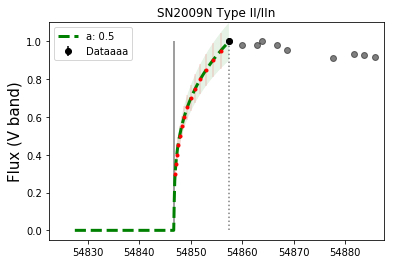

sdss_i' 54857.52
sdss_i'
0.3
sdss_r' 54857.51
sdss_r'
0.3


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


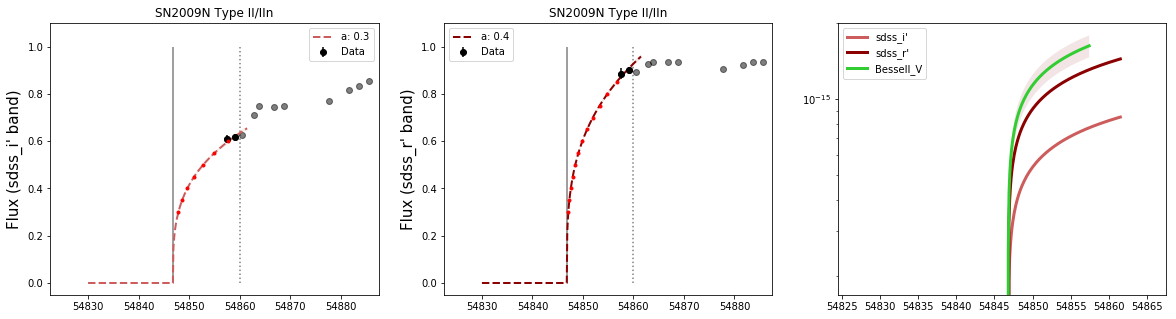

In [304]:
#['SN1999em', 'SN2004et', 'SN2007od', 'SN2008aq', 'SN2008bj', 'SN2008fq',
#           'SN2008in', 'SN2009bw', 'SN2009dd', 'SN2013ab', 'SN2013am', 'SN2013by', 'SN2013df']
for sn in ['SN2009N']:

    SN = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname=sn, verbose=True)
    SN.load()
    SN.get_availfilter()
    SN.clip_photometry(pre_bump= sn in list(pre_bump.keys()))

    lc_file = pd.DataFrame(np.genfromtxt(SN.sn_rawphot_file,
                               names=['MJD','band','Flux','Flux_err','FilterSet', 'Source'], 
                               usecols=[0,1,2,3,4,5], 
                               dtype=None,encoding="utf-8"))
        
    extr_pts_pd = pd.DataFrame().reindex_like(lc_file)[:0]

    # BAND V !!
    band_init = 'Bessell_V' if sn not in ['SN2008aq', 'SN2011ht', 'SN2006aj', 'SN2013ge'] else 'swift_V'
    flux_V = SN.clipped_phot[SN.clipped_phot['filter']==band_init]['flux']
    fluxerr_V = SN.clipped_phot[SN.clipped_phot['filter']==band_init]['flux_err']
    t_V = SN.clipped_phot[SN.clipped_phot['filter']==band_init]['MJD']

    mjd_Vpeak = t_V[np.argmax(flux_V)]
    Vpeak = max(flux_V)
    if sn in pre_bump.keys():
        mjd_Vpeak = explosion_dates[sn][0]+pre_bump[sn][0]
        Vpeak = max(flux_V[t_V>min(t_V)+pre_bump[sn][0]])

    if sn=='SN2005bf': mjd_Vpeak= 53471.
    elif sn=='ASASSN14jb': mjd_Vpeak= 56955.
    elif sn=='SN1987A': mjd_Vpeak= 46870.
    #if sn=='SN2013ge': mjd_Vpeak= 56612.
    if sn=='SN1999dn': mjd_Vpeak= 51417.
    if sn=='SN2006aj': mjd_Vpeak= 53790.
    if sn=='SN2008bo': mjd_Vpeak= 54570.
    if sn=='SN2008aq': mjd_Vpeak= 54528.
    if sn=='SN2009bw': mjd_Vpeak= 54923.
    if sn=='SN2011fu': mjd_Vpeak= 55840.
    if sn=='SN2011hs': mjd_Vpeak= 55885.
    if sn=='SN2011ht': mjd_Vpeak= 55870.
    if sn=='SN2013by': mjd_Vpeak= 56408.
    if sn=='SN2016X': mjd_Vpeak= 57415.
    if sn=='SN2007gr': mjd_Vpeak= 54330.
    if sn=='SN2012A': mjd_Vpeak= 55938.0
    if sn=='SN2007Y': mjd_Vpeak= 54157.0
    if sn=='SN2013ab': mjd_Vpeak= 56345.
    if sn=='SN2008ax': mjd_Vpeak= 54540.
    if sn=='SN2011ei':mjd_Vpeak=55776.8
    if sn=='SN2012au':mjd_Vpeak=56002.5
    if sn=='SN2004gt':mjd_Vpeak=53357.
    if sn=='SN2004gq':mjd_Vpeak=53355.
    if sn=='SN2008bo':mjd_Vpeak=54562.
    if sn=='SN2013am':mjd_Vpeak=56375.
    if sn=='SN2007pk':mjd_Vpeak=54416.
    if sn=='SN2004gv':mjd_Vpeak=53360.

    print (min(t_V))
    plt.plot(t_V, flux_V/Vpeak, 'ok', alpha=0.5)
    
    if np.any(flux_V[t_V<=mjd_Vpeak]<=Vpeak):
        if np.count_nonzero(flux_V[t_V<=mjd_Vpeak]<=Vpeak)==1:
            max_MJD = mjd_Vpeak#t_V[1]#t_V[t_V<mjd_Vpeak][0]
        else:
            max_MJD = mjd_Vpeak#max(t_V[t_V<=mjd_Vpeak][flux_V[t_V<=mjd_Vpeak]<=Vpeak])
    else:
        max_MJD = mjd_Vpeak

    t_ = t_V[t_V<=max_MJD]
    phase_ = t_ - mjd_Vpeak
    flux_ = flux_V[t_V<=max_MJD]/Vpeak
    fluxerr_ = fluxerr_V[t_V<=max_MJD]/Vpeak
    plt.vlines(max_MJD, 0,1, linestyle=':', alpha=0.5)

    R, cov, t_extrapV, fittedV, fittedV_err, t_newpts, newpts_, newpts_err, label_dict, success = performe_fit(sn, band_init, t_, flux_, fluxerr_, phase_, mjd_Vpeak)
    
    plt.errorbar(t_, flux_, yerr=fluxerr_, fmt='ok', label='Dataaaa')
    plt.ylabel('Flux (V band)', fontsize=15)
            
    plt.plot(t_extrapV, fittedV, 'g--', lw=3, label='\n'.join("%s: %.1f"%(k,v) for (k,v) in label_dict))
    plt.fill_between(t_extrapV, fittedV-fittedV_err, fittedV+fittedV_err,
                     facecolor='g', alpha=0.1)

    plt.errorbar(t_newpts, newpts_, yerr=newpts_err, fmt='r.', ecolor='r', elinewidth=0.2)

    plt.xlim(min(min(t_extrapV)-5., -25.+mjd_Vpeak),30.+mjd_Vpeak)
    if sn in pre_bump.keys(): plt.xlim((explosion_dates[sn][0]-2.),20.+mjd_Vpeak)
    
    if sn in se_sne: plt.title(sn+ '_SESN')
    else: plt.title(sn+ ' Type II/IIn')
    plt.ylim(-0.05, max(max(fittedV),1.1))
    plt.legend()
    plt.show()
    
    if success:
        extr_pts_pd['MJD'] = t_newpts
        extr_pts_pd['band'] = np.full(len(t_newpts), fill_value=band_init)
        extr_pts_pd['Flux'] = newpts_*Vpeak
        extr_pts_pd['Flux_err'] = newpts_err*Vpeak
        extr_pts_pd['FilterSet'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
        extr_pts_pd['Source'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
        lc_file = lc_file.append(extr_pts_pd)    
    
    i=1
    early_bands=[]
    exclude_bands = exclude_dict[sn] if sn in exclude_dict else []
    include_bands = include_dict[sn] if sn in include_dict else []

    for band in np.unique(SN.clipped_phot['filter']):
        t_x = SN.clipped_phot[SN.clipped_phot['filter']==band]['MJD']
        if (min(t_x)<=min(t_V)+0.5)&(len(t_x[t_x<=max_MJD])>=1):
            if (sn in se_sne)&(band not in [band_init, 'swift_UVW1','swift_UVW2', 'swift_UVM2'])&(band not in exclude_bands):
                early_bands.append(band)
            elif (sn not in se_sne)&(band not in [band_init, 'swift_U', 'Bessell_U', 'swift_UVW1',
                                               'swift_UVW2', 'swift_UVM2'])&(band not in exclude_bands):
                early_bands.append(band)
        if (band in include_bands):
            if band not in early_bands: early_bands.append(band)

    N_rows = int(len(early_bands)/3)+1
    fig = plt.figure(figsize=(20,N_rows*5))
        
    for band in early_bands:
        plt.subplot(N_rows,3,i)
        flux_x = SN.clipped_phot[SN.clipped_phot['filter']==band]['flux']
        fluxerr_x = SN.clipped_phot[SN.clipped_phot['filter']==band]['flux_err']
        t_x = SN.clipped_phot[SN.clipped_phot['filter']==band]['MJD']
        xpeak = max(flux_x)
        mjd_xpeak = t_x[np.argmax(flux_x)]
        if sn in pre_bump.keys():
            mjd_xpeak = explosion_dates[sn][0]+pre_bump[sn][0]
            xpeak = max(flux_x[t_x>mjd_xpeak])
            
        print (band, min(t_x))
        if sn=='SN2005bf': mjd_xpeak= 53471.
        if sn=='ASASSN14jb': mjd_xpeak= 56953.
        if sn=='SN1987A': mjd_xpeak= 46870.
        if sn=='SN1999dn': mjd_xpeak= 51416.
        if sn=='SN2006aj': mjd_xpeak= 53790.
        if sn=='SN2008aq': mjd_xpeak= 54528.
        if sn=='SN2008bo': mjd_xpeak= 54570.
        if sn=='SN2009bw': mjd_xpeak= 54923.
        if sn=='SN2011fu': mjd_xpeak= 55585.
        if sn=='SN2011hs': mjd_xpeak= 55885.
        if sn=='SN2011ht': mjd_xpeak= 55870.
        if sn=='SN2013by': 
            mjd_xpeak= 56407.5
            if band=='sdss_u':mjd_xpeak=56407.
        if sn=='SN2016X': mjd_xpeak= 57415.
        if sn=='SN2007gr': mjd_xpeak= 54333.5
        if sn=='SN2012A': mjd_xpeak= 55940.0
        if sn=='SN2007Y': mjd_xpeak= 54157.0
        if sn=='SN2013ab': mjd_xpeak= 56345.
        if sn=='SN2007ru': mjd_xpeak= 54440.
        if sn=='SN2008ax': mjd_xpeak= 54540.
        if sn=='SN2009ib': mjd_xpeak= 55060.
        if sn=='SN2009N': mjd_xpeak= 54860.
        if sn=='SN2011ei':mjd_xpeak=55776.8
        if sn=='SN2012au':mjd_xpeak=56002.5
        if sn=='SN2004gt':mjd_xpeak=53357.
        if sn=='SN2004gq':mjd_xpeak=53355.
        if sn=='SN2008bo':mjd_xpeak=54563.
        if sn=='SN2013am':mjd_xpeak=56378.
        if sn=='SN2007pk':mjd_xpeak=54416.
        if sn=='SN2004gv':mjd_xpeak=53360.


        plt.plot(t_x, flux_x/xpeak, 'ok', alpha=0.5)
        
        if np.any(flux_x[t_x<=mjd_xpeak]<=xpeak):
            if np.count_nonzero(flux_x[t_x<=mjd_xpeak]<=xpeak)==1:
                max_MJD = mjd_xpeak#t_x[1]
            else:
                max_MJD = mjd_xpeak#max(t_x[t_x<=mjd_xpeak][flux_x[t_x<=mjd_xpeak]<=xpeak])
        else:
            max_MJD = mjd_xpeak

        t_ = t_x[t_x<=max_MJD]
        phase_ = t_ - mjd_Vpeak
        flux_ = flux_x[t_x<=max_MJD]/xpeak
        fluxerr_ = fluxerr_x[t_x<=max_MJD]/xpeak
        plt.xlim(min(min(t_extrapV)-5., -25.+mjd_Vpeak),30.+mjd_Vpeak)
        if sn in pre_bump.keys(): plt.xlim((explosion_dates[sn][0]-2.),20.+mjd_Vpeak)
        print (band)
        plt.vlines(max_MJD, 0,1, linestyle=':', alpha=0.5)

        results = performe_fit(sn, band, t_, flux_, fluxerr_, phase_, mjd_xpeak)
        R, cov, t_extrap, fitted, fitted_err, t_newpts, newpts_, newpts_err, label_dict, success= results
        
        plt.errorbar(t_, flux_, yerr=fluxerr_, fmt='ok', label='Data')
        
        plt.ylabel('Flux (%s band)'%band, fontsize=15)
        plt.plot(t_extrap, fitted, '--', color=color_dict[band], lw=2,
                 label='\n'.join("%s: %.1f"%(k,v) for (k,v) in label_dict))
        plt.fill_between(t_extrap, fitted-fitted_err, fitted+fitted_err,
                     facecolor=color_dict[band], alpha=0.1)
        plt.errorbar(t_newpts, newpts_, yerr=newpts_err, fmt='r.', ecolor='r', elinewidth=0.2)
        plt.ylim(-0.05, max(max(fitted),1.1))
        
        if sn in se_sne: plt.title(sn+ '_SESN')
        else: plt.title(sn+ ' Type II/IIn')
        plt.legend()
        i=i+1
   
        if success:
            extr_pts_pd = pd.DataFrame().reindex_like(lc_file)[:0]
            extr_pts_pd['MJD'] = t_newpts
            extr_pts_pd['band'] = np.full(len(t_newpts), fill_value=band)
            extr_pts_pd['Flux'] = newpts_ * xpeak
            extr_pts_pd['Flux_err'] = newpts_err * xpeak
            extr_pts_pd['FilterSet'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
            extr_pts_pd['Source'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
            lc_file = lc_file.append(extr_pts_pd)    
        plt.subplot(N_rows,3,N_rows*3)
        plt.plot(t_extrap, fitted*xpeak, '-', color=color_dict[band], lw=3,
                 label=band)
        plt.fill_between(t_extrap, (fitted-fitted_err)*xpeak, (fitted+fitted_err)*xpeak,
                     facecolor=color_dict[band], alpha=0.1)
    plt.subplot(N_rows,3,N_rows*3)
    plt.plot(t_extrapV, fittedV*Vpeak, '-', color=color_dict['Bessell_V'], lw=3,
                 label='Bessell_V')
    plt.fill_between(t_extrapV, Vpeak*(fittedV-fittedV_err), Vpeak*(fittedV+fittedV_err),
                     facecolor=color_dict[band], alpha=0.1)
    plt.xlim(min(min(t_extrapV)-3., -25.+mjd_Vpeak),10.+mjd_Vpeak)
    plt.legend()
    plt.yscale('log')
    plt.show()
    plt.close(fig)
    
    lc_file.to_csv(SN.sn_rawphot_file.replace('/Final_LC_NOMW_dust_corr/','/Final_LC_NOMW_early_extrapolation/'), na_rep='nan',
              index=False, sep='\t', header=['#MJD','band','Flux','Flux_err','FilterSet','Source'])



In [295]:
D_n_hydr_avg={}

for n,filt in n_hydr_avg:
    f = filt.replace('swift_', '').replace('Bessell_', '').replace('sdss_', '').replace("'", '').upper()
    D_n_hydr_avg[f] = []

for n,filt in n_hydr_avg:
    f = filt.replace('swift_', '').replace('Bessell_', '').replace('sdss_', '').replace("'", '').upper()
    plt.plot(f, n, 'o')
    D_n_hydr_avg[f] = D_n_hydr_avg[f] + [n]

In [292]:
#for f in D_n_hydr_avg.keys():
#    plt.hist(D_n_hydr_avg[f], alpha=0.3, label=f)
#    print (f, '%.2f %.2f'%(np.mean(D_n_hydr_avg[f]), np.std(D_n_hydr_avg[f])))
#plt.legend()
#plt.show()
for f in ['U', 'B','G','V', 'R', 'I']:
    plt.errorbar(f, np.mean(D_n_hydr_avg[f]), yerr=np.std(D_n_hydr_avg[f]), fmt='o', label=f)
plt.legend()



KeyError: 'U'

In [ ]:
sdss = 0.96, +1.10, -0.77
snls = 0.91, +1.42, -0.59

## Type II try Bazin fit


In [55]:
trise_typeII=[]
def performe_fit(sn, filt, t_, flux_, fluxerr_, phase_, mjd_Vpeak):

    t0_fix, t0_lower, t0_upper = explosion_dates[sn]
    if t0_lower:
        p_t0 = t0_lower+1.
    else: 
        t0_lower = mjd_Vpeak-100.
        p_t0 = min(min(phase_),-15.)+mjd_Vpeak

    if t0_upper:
        p_t0 = t0_upper-1.
    else: 
        t0_upper = mjd_Vpeak
    
    if (isinstance(t0_fix, float)):
        #names=['A', 'B', 'tfall', 'trise']
        #def fit(x, A, B, tfall, trise):
        #    t0 = t0_fix
        #    #f_t = np.zeros(len(x))
        #    #f_t[x>t0] = a * (x[x>t0]-t0)**n
        #    f_t = ( A * ( np.exp((-x+t0)/tfall) ))/( 1.+np.exp(x-t0)/trise) +B
        #    return f_t
        #
        #p0 = [1.,0.1,20.,-5.]
        #bounds=([0.,0.,1.,-40.],[100.,100.,1000.,1.])   
        #plt.vlines(t0_fix, 0,1, linestyle='-', alpha=0.5)
        t_ = np.concatenate([[t0_fix-0.5], t_])
        flux_ = np.concatenate([[0.], flux_])
        fluxerr_ = np.concatenate([[min(fluxerr_)], fluxerr_])
        
        names=['A', 't0', 'tfall', 'trise']
        def Bazin(t, A, t0, tfall, trise):
            up = np.exp( -(t-t0)/(tfall) )
            down = np.exp( 1.+ np.exp( (t-t0)/(trise) ))
            return A*up/down

        p0 = p0=[1.6,t0_fix, 50.,-8.]
        bounds=([0.,t0_fix-20.,2., -40.],[10.,t0_fix+20.,np.inf, 1.])   

    elif (~isinstance(t0_fix, float)):
        names=['A', 't0', 'tfall', 'trise']
        def Bazin(t, A, B, t0, tfall, trise):
            up = np.exp( -(t-t0)/(tfall) )
            down = np.exp( 1.+ np.exp( (t-t0)/(trise) ))
            return A*up/down

        p0 = p0=[1.6,t0_fix, 50.,-8.]
        bounds=([0.,t0_fix-20.,2., -40.],[10.,t0_fix+20.,np.inf, 1.])   

    else:
        pass
    
    plt.errorbar(t_, flux_, yerr=fluxerr_, fmt='ok', label='Data')

    R,cov = opt.curve_fit(Bazin, t_, flux_, p0=p0, bounds=bounds,
                        sigma=fluxerr_, maxfev=10000)
        
    explos_day = R[np.array(names)=='t0'][0]
    plt.vlines(explos_day, 0,1, color='r', linestyle='-', alpha=0.5, label='t0 from fit')
    plt.vlines(t0_fix, 0,1, color='b', linestyle='-', alpha=0.5, label='t0= explosion date')

        
    dT = 0.25 if sn not in pre_bump.keys() else 0.1    
    t_newpts = np.arange(explos_day+0.05, min(t_), dT)
    t_extrap = np.arange(min(explos_day-5., -30.+mjd_Vpeak), max(phase_)+mjd_Vpeak,0.1)

    if np.any(np.isinf(cov)): 
        print ('#######################'+'COVARIANCE MATRIX inf')
        fit_ = Bazin(t_extrap, *R)
        fit_err = 0.2*fit_#np.zeros(len(fit_))

        newpts_ = Bazin(t_newpts, *R)
        newpts_err = 0.2*newpts_ #np.zeros(len(newpts_))
        success=True
    else:
        rand = np.random.multivariate_normal(R, cov, size=10000)
    
        fit_ = Bazin(t_extrap, *R)
        fit_err = pd.DataFrame(Bazin(t_extrap, *par) for par in rand).std().values

        newpts_ = Bazin(t_newpts, *R)
        newpts_err = pd.DataFrame(Bazin(t_newpts, *par) for par in rand).std().values
        success=True

    trise_typeII.append((R[np.array(names)=='trise'][0],filt))

    return R, cov, t_extrap, fit_, fit_err, t_newpts, newpts_, newpts_err, dict(zip(names, np.round(R,1))).items() , success



In [56]:
Bazin_t0_dict={"SN2006T" :(53775.33 , 0.14),
"SN2016X" :(57408.22 , 0.02),
"SN2011hs" :(55882.78 , 0.09),
"SN2011ht" :(55875.16 , 0.55),
"SN2004gt" :(53354.58 , 0.07),
"SN2005hg" :(53677.11 , 0.16),
"SN2008ax" :(54541.15 , 0.11),
"SN2007Y" :(54157.12 , 0.14),
"SN2013fs" :(56571.63 , 0.02),
"SN2016bkv" :(57470.43 , 0.01),
"ASASSN15oz" :(57264.76 , 0.09),
"SN2013ej" :(56500.31 , 0.02),
"SN2007od" :(54407.69 , 0.15),
"SN2013am" :(56372.57 , 0.04),
"SN2009dd" :(54931.45 , 0.22),
"SN2008in" :(54826.90 , 0.71),
"SN2004gv" :(53359.84 , 0.16),
"SN2013by" :(56405.77 , 0.03),
"SN2014G" :(56672.83 , 0.05),
"SN2007ru" :(54435.30 , 0.07),
"SN2009ip" :(56198.67 , 0.07),
"iPTF13bvn" :(56469.88 , 0.13),
"SN1998bw" :(50939.86 , 0.19),
"SN1999em" :(51478.55 , 0.23),
"SN2013ab" :(56342.08 , 0.04),
"SN2012A" :(55933.02 , 0.25),
"SN2016gkg" :(57662.76 , 0.20),
"SN2006ep" :(53980.72 , 0.11),
"SN2011bm" :(55662.00 , 0.12),
"SN2009N" :(54852.54 , 0.26),
"SN2013ge" :(56611.77 , 0.19),
"SN2008bo" :(54559.75 , 0.23),
"SN2009bb" :(54915.66 , 0.07),
"SN2012au" :(55999.49 , 0.06),
"SN2008bj" :(54544.56 , 0.54),
"ASASSN14jb" :(56948.27 , 0.15),
"SN2007gr" :(54332.10 , 0.10),
"SN2012ap" :(55970.06 , 0.06),
"SN2005cs" :(53549.43 , 0.02),
"SN2004fe" :(53312.73 , 0.11),
"SN2002ap" :(52307.60 , 0.03),
"SN1994I" :(49446.91 , 0.16),
"SN2007uy" :(54474.54 , 0.12),
"SN2004et" :(53274.12 , 0.10),
"SN2011ei" :(55776.07 , 0.18),
"SN2007pk" :(54414.74 , 0.03),
"SN2004gq" :(53352.01 , 0.06),
"SN2008aq" :(54524.51 , 5.29),
"SN2006aa" :(53776.40 , 0.38),
"SN2009iz" :(55102.86 , 0.30),
"SN2009ib" :(55046.44 , 0.40),
"SN2009bw" :(54919.88 , 0.05),
"SN1999dn" :(51412.66 , 0.15),
"SN2009kr" :(55142.75 , 0.05),
"SN2012aw" :(56003.45 , 0.02),
"SN2008fq" :(54723.77 , 0.08),
"SN2010al" :(55283.16 , 0.37),
"SN2004aw" :(53087.41 , 0.69)}

In [113]:
trise_typeII=[]
def performe_fit(sn, filt, t_, flux_, fluxerr_, phase_, mjd_Vpeak):

    t0_fix, t0_lower, t0_upper = explosion_dates[sn]
    if ('U' in filt)|('u' in filt)|(('B' in filt)): lower_rise = 0.45
    else: lower_rise = 0.85
        
    
    if (isinstance(t0_fix, float)):
        t_ = np.concatenate([[t0_fix-0.5], t_])
        flux_ = np.concatenate([[0.], flux_])
        fluxerr_ = np.concatenate([[min(fluxerr_)], fluxerr_])
        
    #elif (~isinstance(t0_fix, float)):
    names=['A', 't0', 'tfall', 'trise']
    avg_t0 = Bazin_t0_dict[sn][0]
    avg_t0_err = Bazin_t0_dict[sn][1]

    def Bazin(t, A, t0, tfall, trise):
        #
        up = np.exp( -(t-t0)/(tfall) )
        down = np.exp( 1.+ np.exp( -(t-t0)/(trise) ))
        return A*up/down
    
    p0 =[3., avg_t0, 50.,3.]
    bounds=([1., avg_t0-3*avg_t0_err, 2., lower_rise],[100., avg_t0+3*avg_t0_err, np.inf,40.])   
    
    plt.errorbar(t_, flux_, yerr=fluxerr_, fmt='ok', label='Data')

    try:
        R,cov = opt.curve_fit(Bazin, t_, flux_, p0=p0, bounds=bounds,
                        sigma=fluxerr_)
    except RuntimeError:
        try:
            R,cov = opt.curve_fit(Bazin, t_[:6], flux_[:6], p0=p0, bounds=bounds,
                        sigma=fluxerr_[:6])
        except RuntimeError:
            R = np.array(p0)
            cov = np.full((4,4), fill_value=np.inf)

    explos_day = Bazin_t0_dict[sn][0]#R[np.array(names)=='t0'][0]
    explos_day_err = Bazin_t0_dict[sn][1]#np.sqrt(np.diag(cov))[np.array(names)=='t0'][0]

    plt.vlines(explos_day, 0,1, color='r', linestyle='-', alpha=0.5, label='t0 from fit')
    plt.vlines(t0_fix, 0,1, color='b', linestyle='-', alpha=0.5, label='t0= explosion date')
        
    dT = 0.25 if sn not in pre_bump.keys() else 0.1    
    t_newpts = np.arange(explos_day+0.05, min(t_), dT)
    t_extrap = np.arange(min(explos_day-5., -30.+mjd_Vpeak), max(phase_)+mjd_Vpeak,0.1)
    
    if np.any(np.isinf(cov)): 
        print ('#######################'+'COVARIANCE MATRIX inf')
        fit_ = Bazin(t_extrap, *R)
        fit_err = 0.2*fit_#np.zeros(len(fit_))
    
        newpts_ = Bazin(t_newpts, *R)
        newpts_err = 0.2*newpts_ #np.zeros(len(newpts_))
        success=False
    else:
        rand = np.random.multivariate_normal(R, cov, size=1000)
        
        fit_ = Bazin(t_extrap, *R)
        fit_err = pd.DataFrame(Bazin(t_extrap, *par) for par in rand).std().values
    
        newpts_ = Bazin(t_newpts, *R)
        newpts_err = pd.DataFrame(Bazin(t_newpts, *par) for par in rand).std().values
        success=True
    
    trise_typeII.append((sn, R[np.array(names)=='trise'][0],filt, explosion_dates[sn][0], explos_day, explos_day_err, mjd_Vpeak))

    return R, cov, t_extrap, fit_, fit_err, t_newpts, newpts_, newpts_err, dict(zip(names, np.round(R,1))).items() , success




In [114]:
type_ii = np.unique(['SN2005cs', 'SN2007pk',
'SN2008fq',  'SN2009dd', 'SN2013am', 'SN2013ej', 'SN2013fs', 'SN2014G', 'SN2008bj',  'SN2013ab', 'SN2012aw',
'SN2009N', 'SN1999em', 'SN2009bw', 'SN2004et', 'SN2013by', 'SN2016X', 'SN2007od', 
'SN2008in', 'SN2012A', 'SN2016bkv',  'SN2009kr', 'ASASSN15oz', 'ASASSN14jb', 'SN2009ib'])



In [115]:
sn_list_nobump =[]
for sn in (sn_list):
    if (sn not in pre_bump)&(sn!='SN2005bf')&(sn!='SN2009jf'): sn_list_nobump.append(sn)

Looking for Photometry for ASASSN14jb in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//ASASSN14jb.dat
Got it!
Photometry loaded


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:22: RuntimeWarning: overflow encountered in exp


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:21: RuntimeWarning: overflow encountered in exp


Looking for Photometry for ASASSN15oz in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//ASASSN15oz.dat
Got it!
Photometry loaded


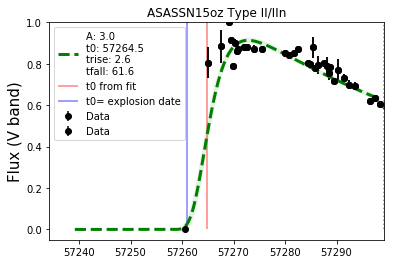

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:60: RuntimeWarning: covariance is not positive-semidefinite.
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


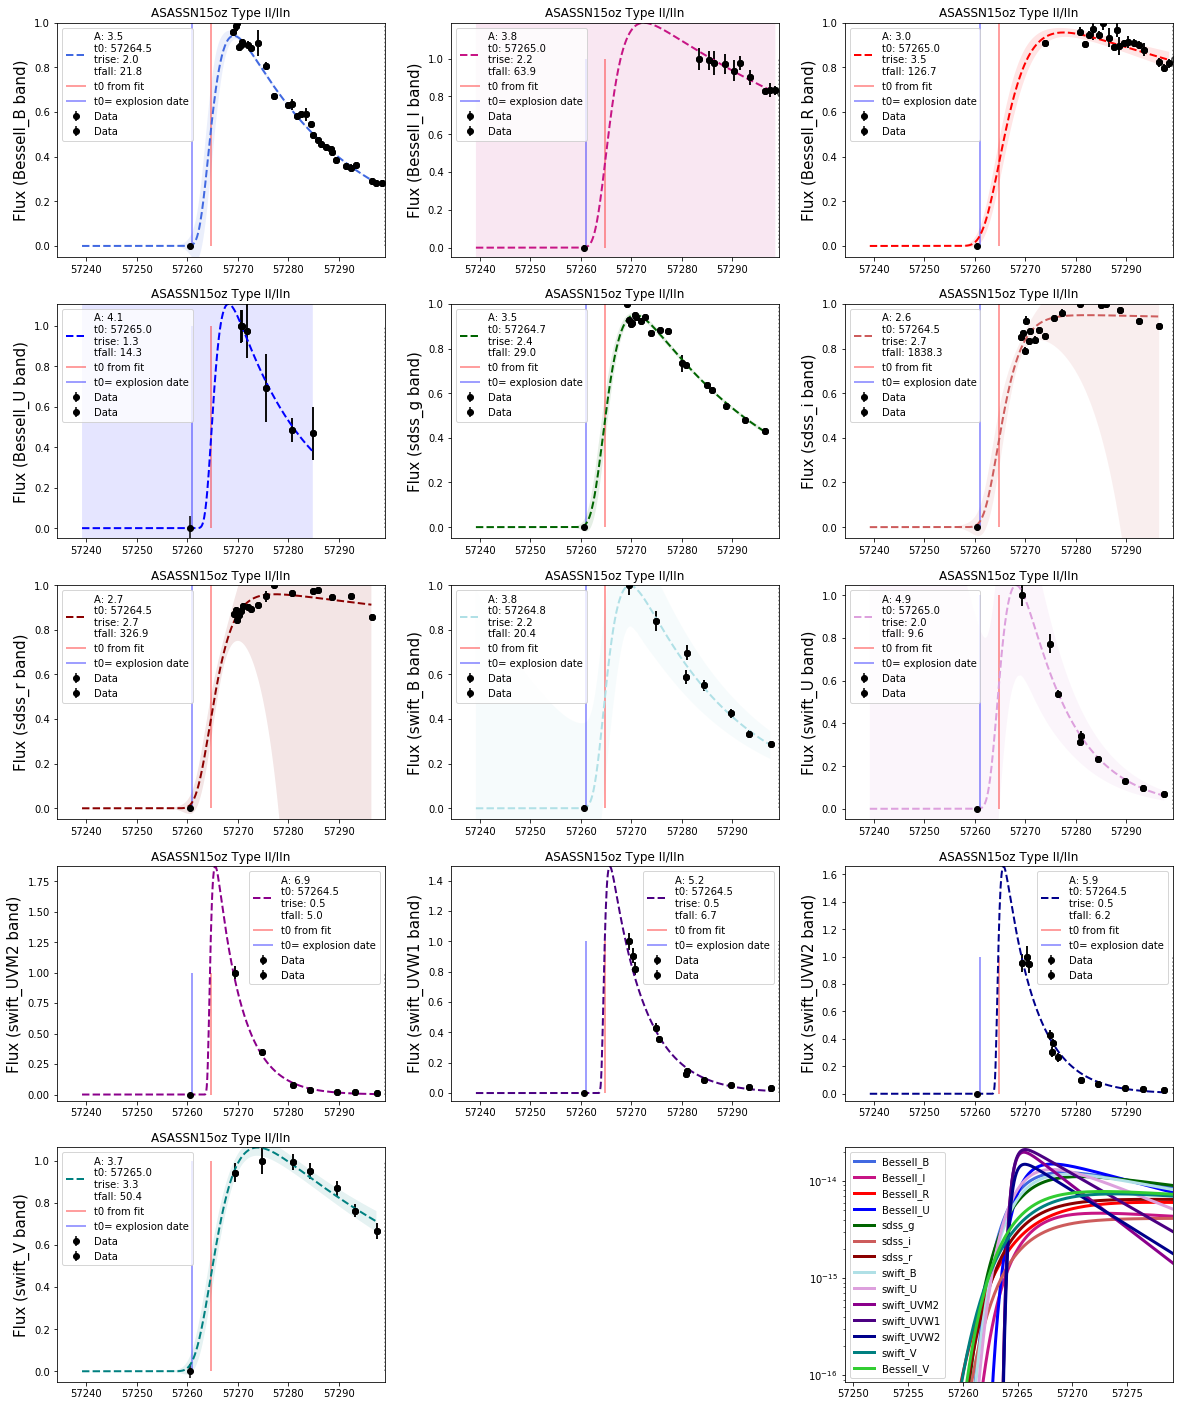

Looking for Photometry for SN1999em in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN1999em.dat
Got it!
Photometry loaded


Looking for Photometry for SN2004et in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2004et.dat
Got it!
Photometry loaded


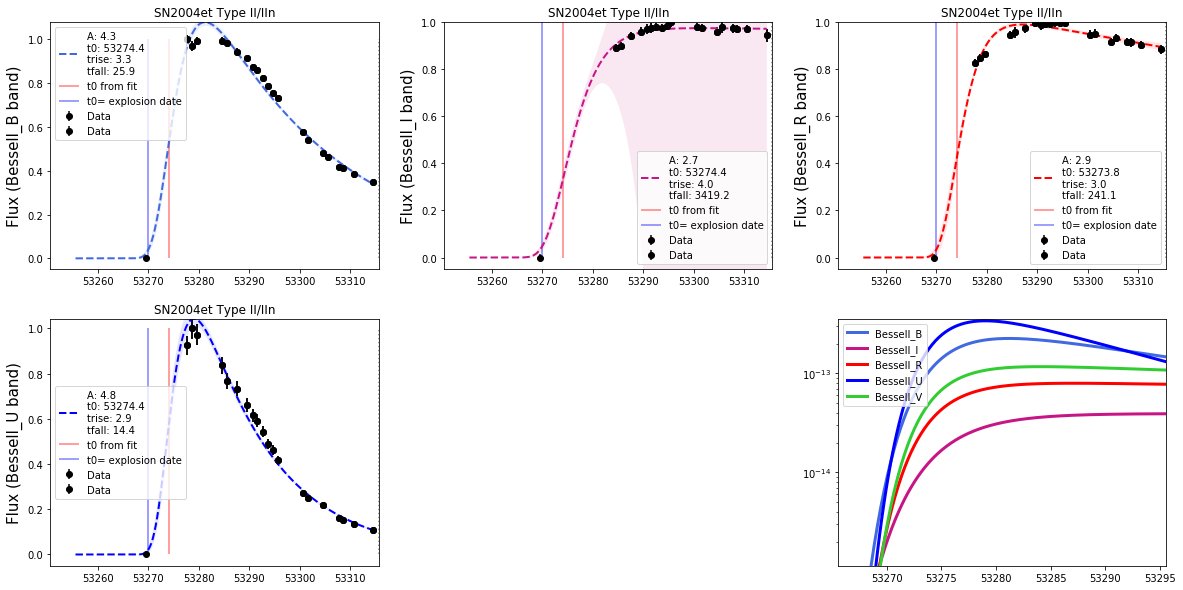

Looking for Photometry for SN2005cs in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2005cs.dat
Got it!
Photometry loaded


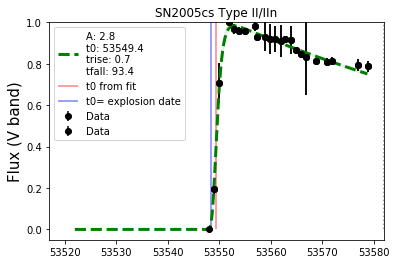

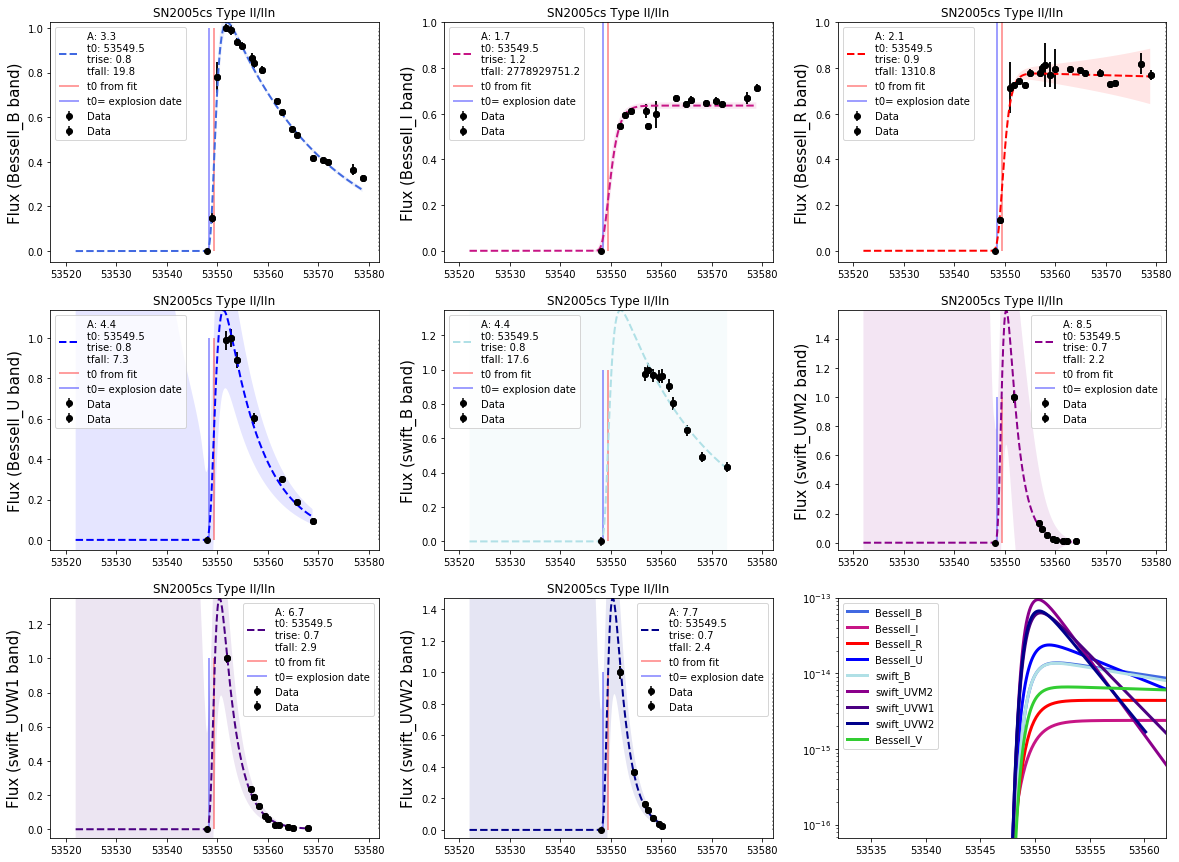

Looking for Photometry for SN2007od in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2007od.dat
Got it!
Photometry loaded


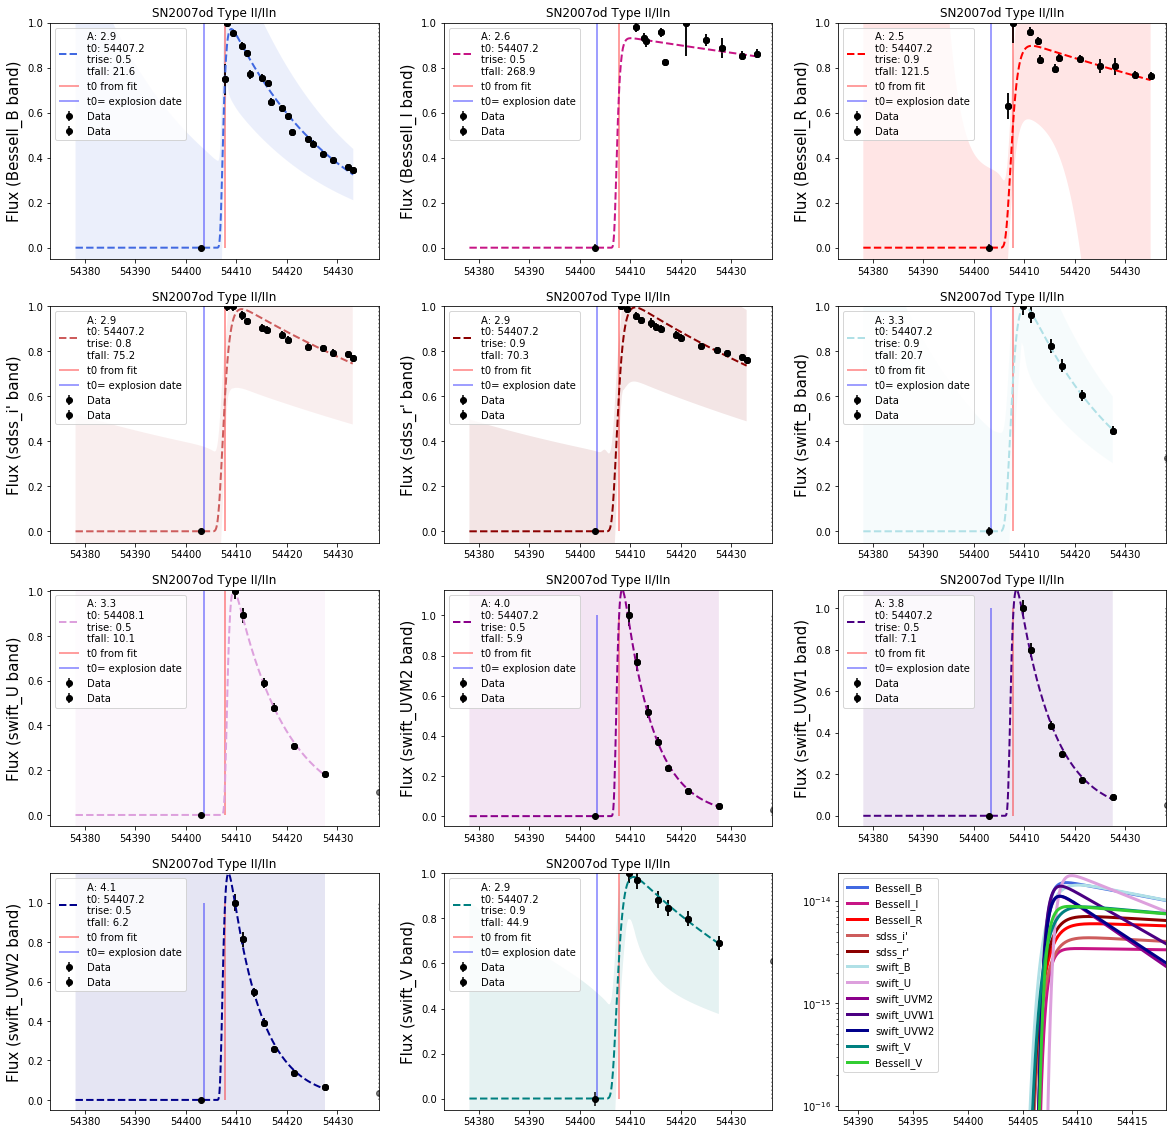

Looking for Photometry for SN2007pk in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2007pk.dat
Got it!
Photometry loaded


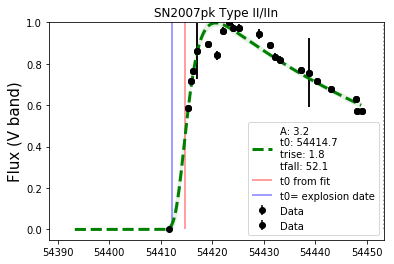

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:23: RuntimeWarning: overflow encountered in multiply


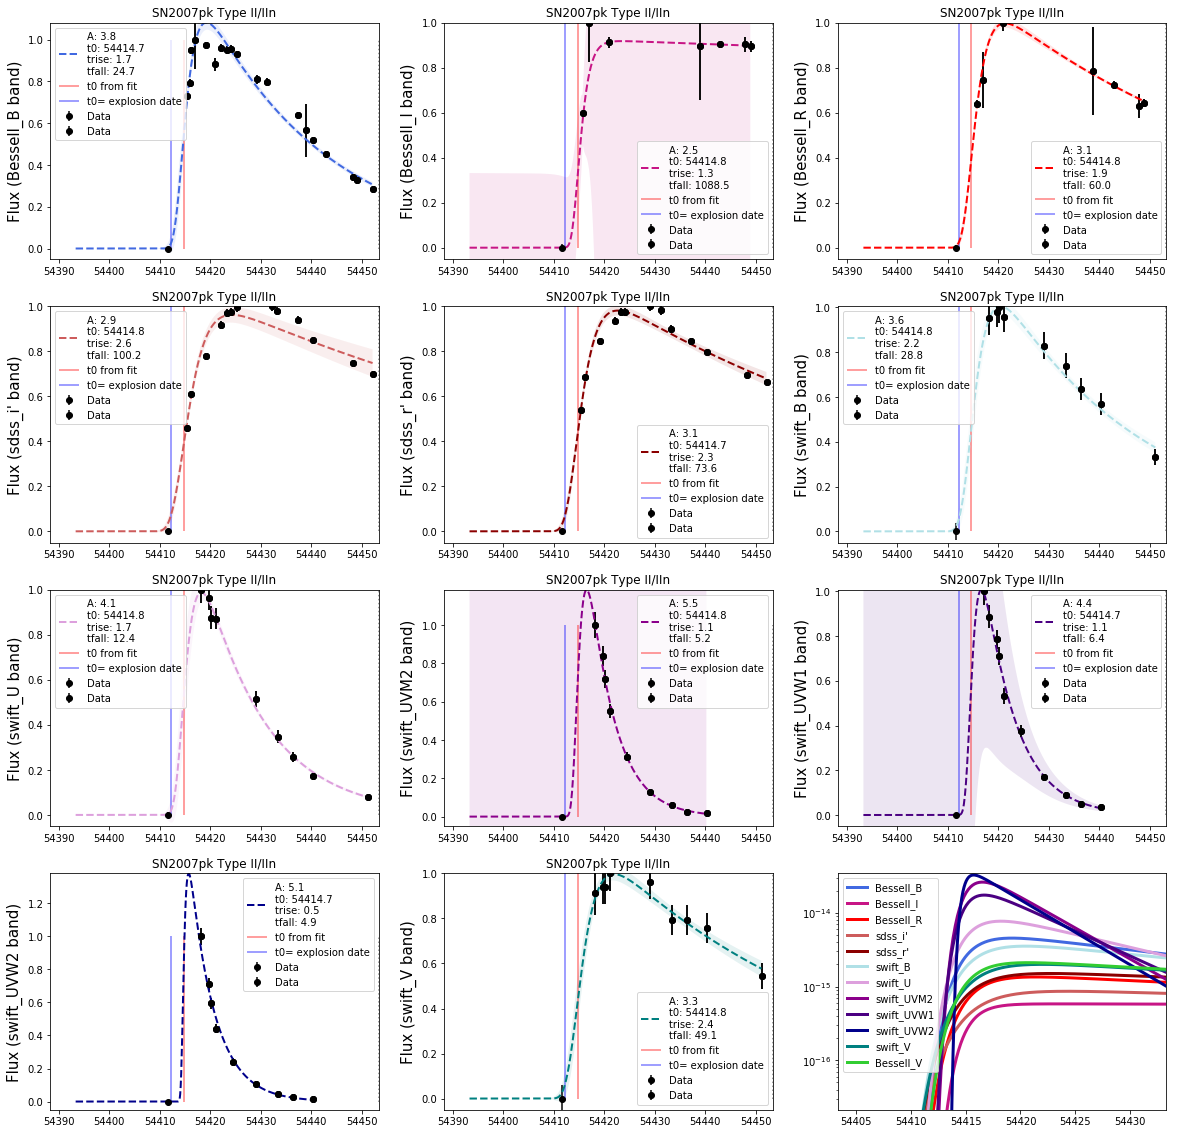

Looking for Photometry for SN2008bj in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2008bj.dat
Got it!
Photometry loaded


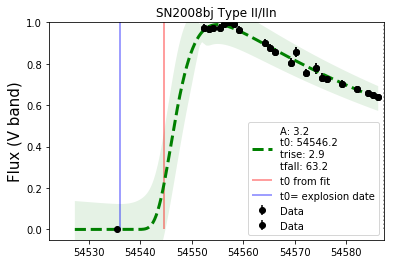

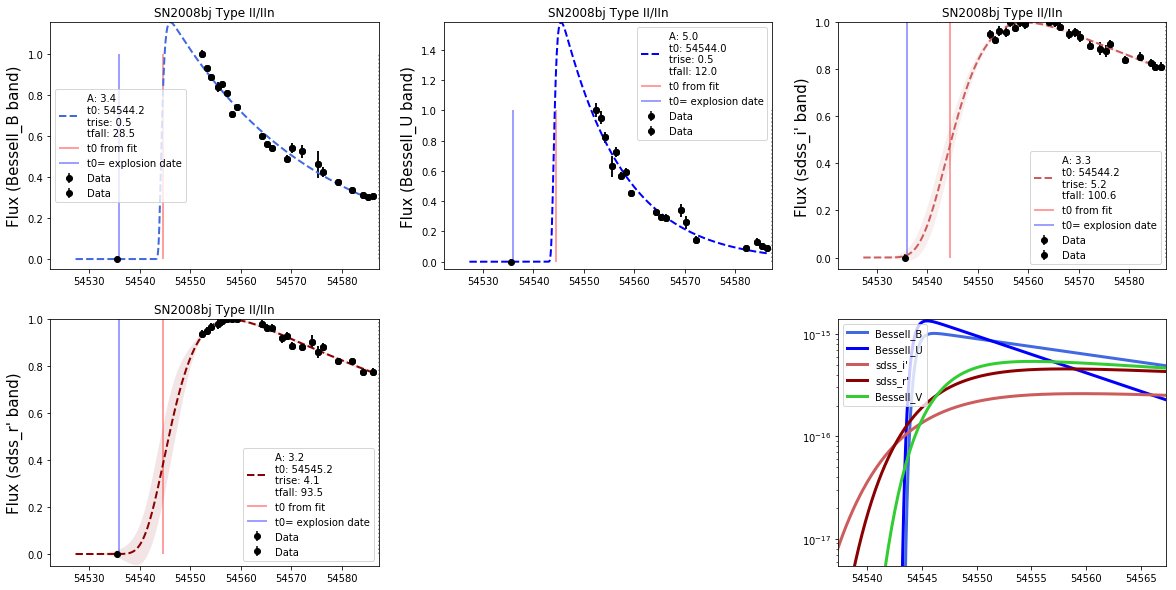

Looking for Photometry for SN2008fq in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2008fq.dat
Got it!
Photometry loaded


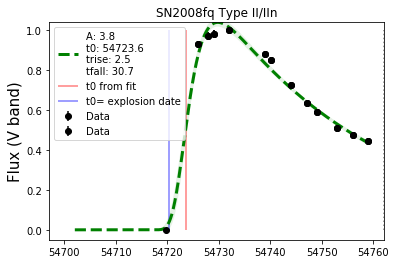

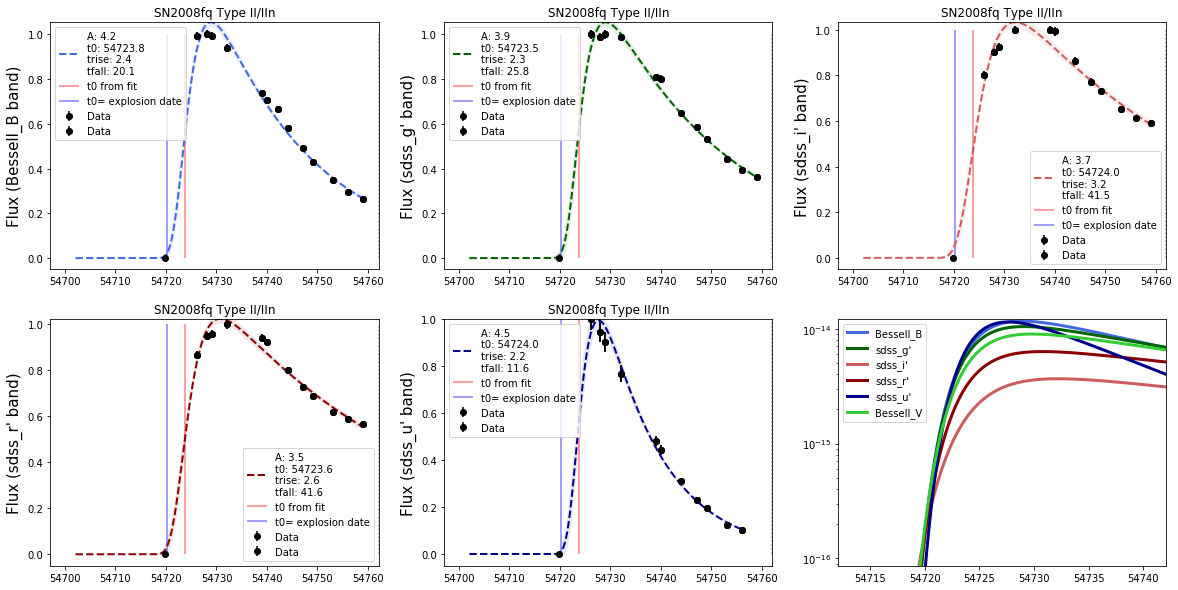

Looking for Photometry for SN2008in in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2008in.dat
Got it!
Photometry loaded


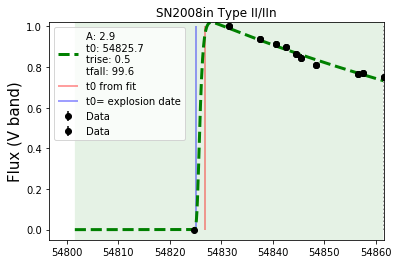

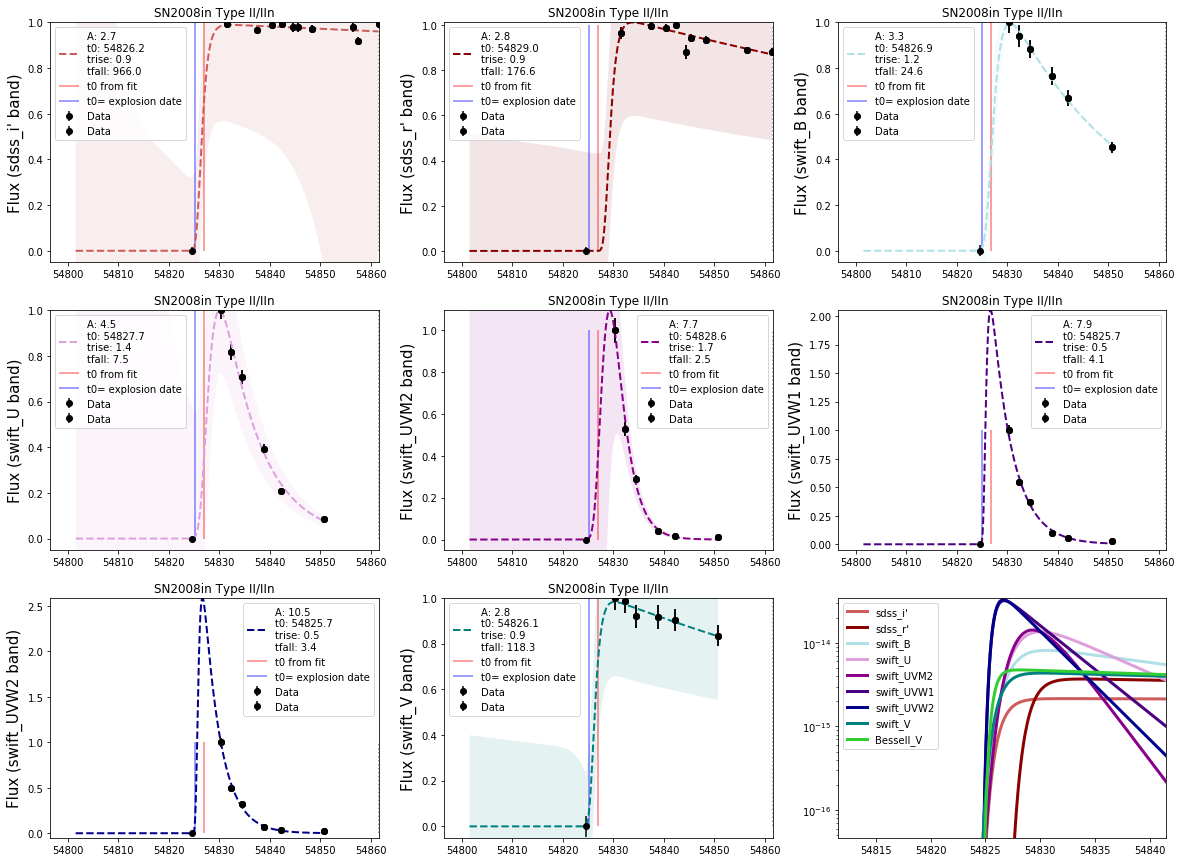

Looking for Photometry for SN2009N in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2009N.dat
Got it!
Photometry loaded


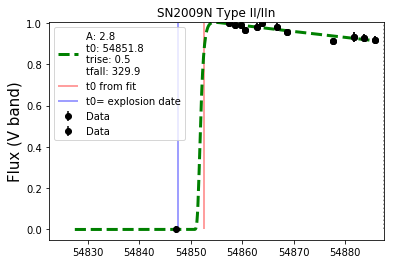

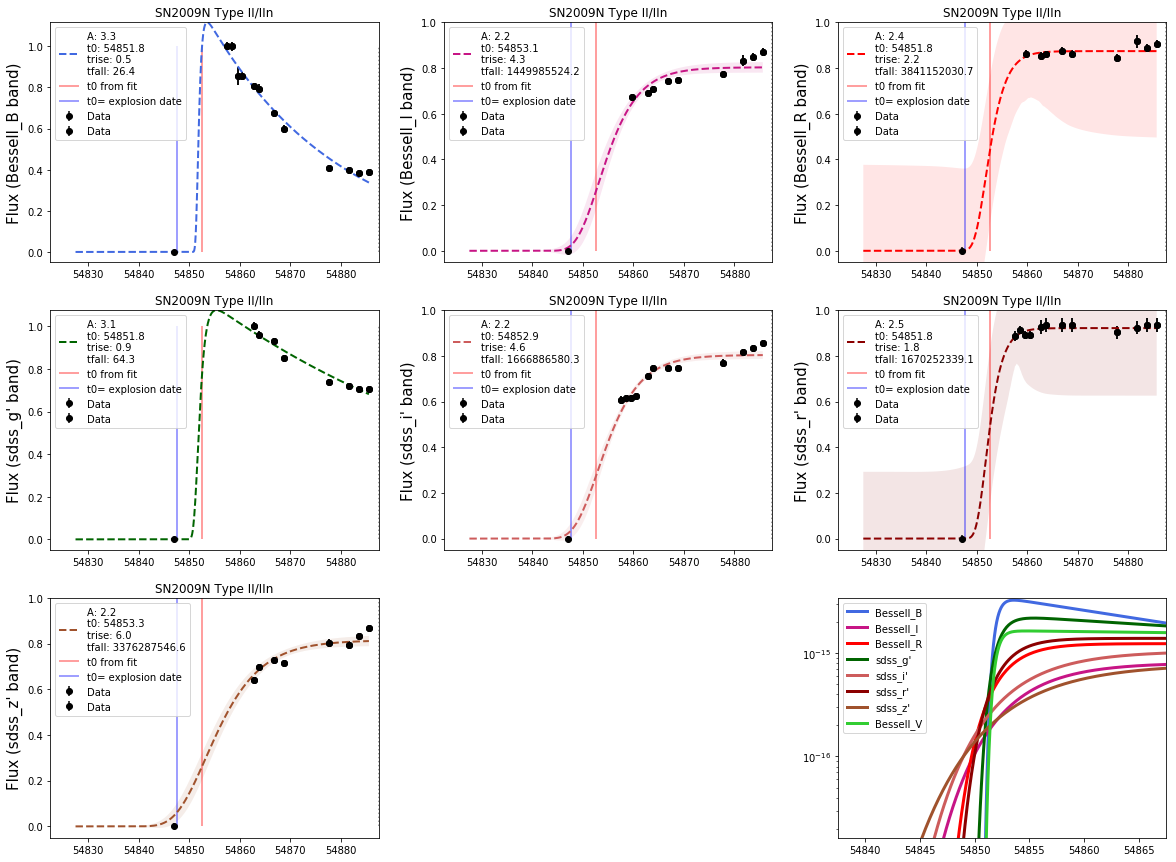

Looking for Photometry for SN2009bw in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2009bw.dat
Got it!
Photometry loaded


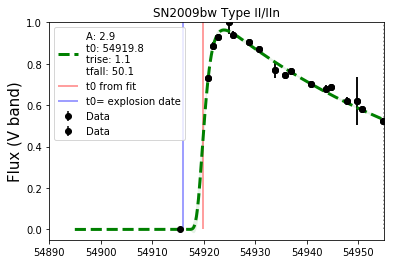

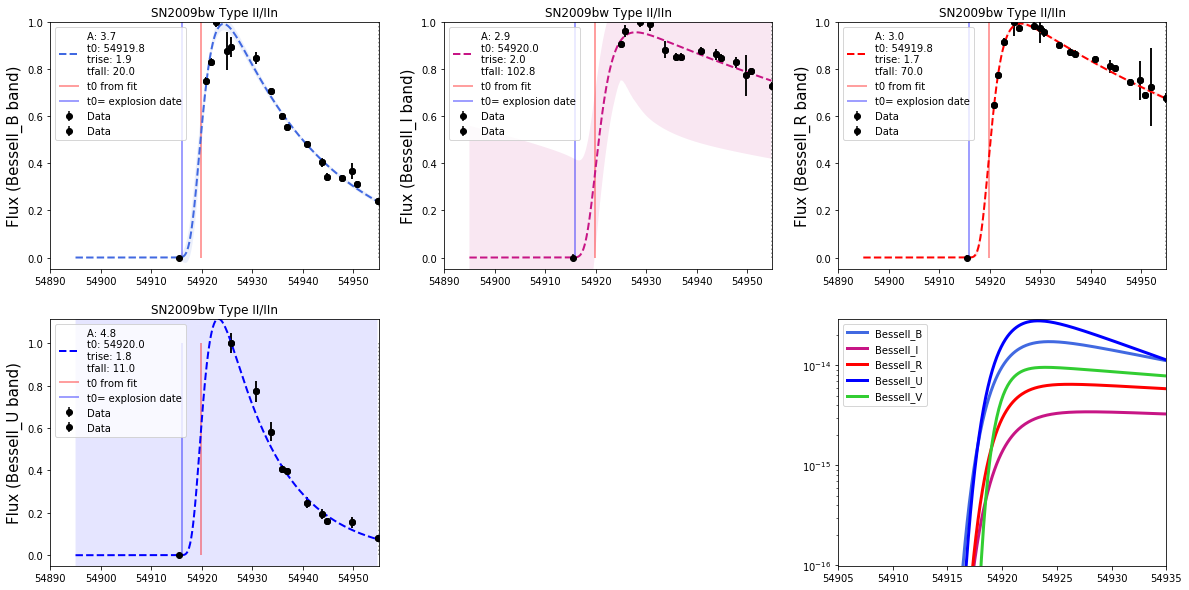

Looking for Photometry for SN2009dd in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2009dd.dat
Got it!
Photometry loaded


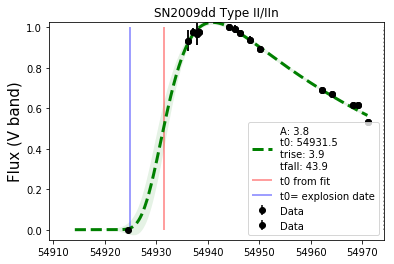

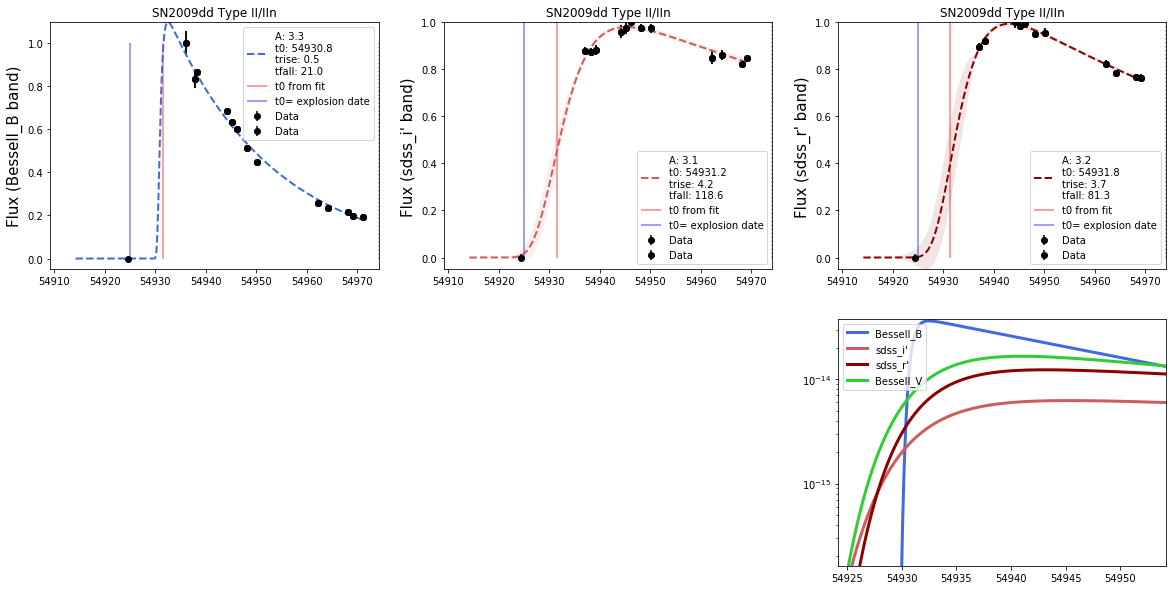

Looking for Photometry for SN2009ib in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2009ib.dat
Got it!
Photometry loaded


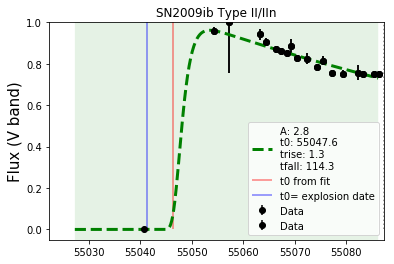

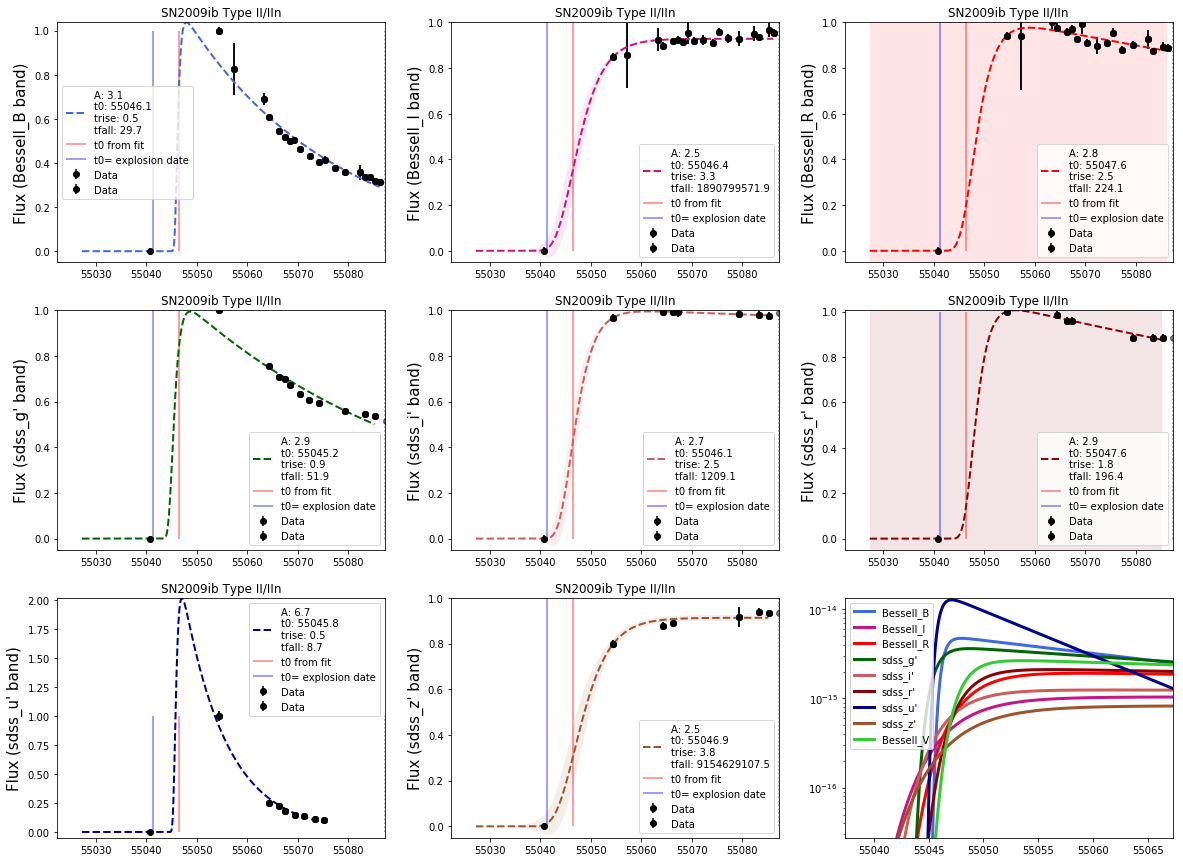

Looking for Photometry for SN2009kr in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2009kr.dat
Got it!
Photometry loaded


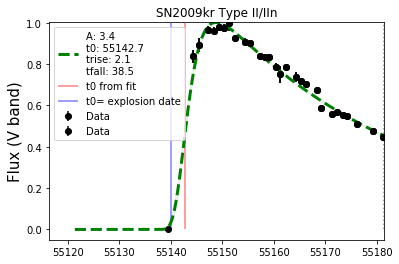

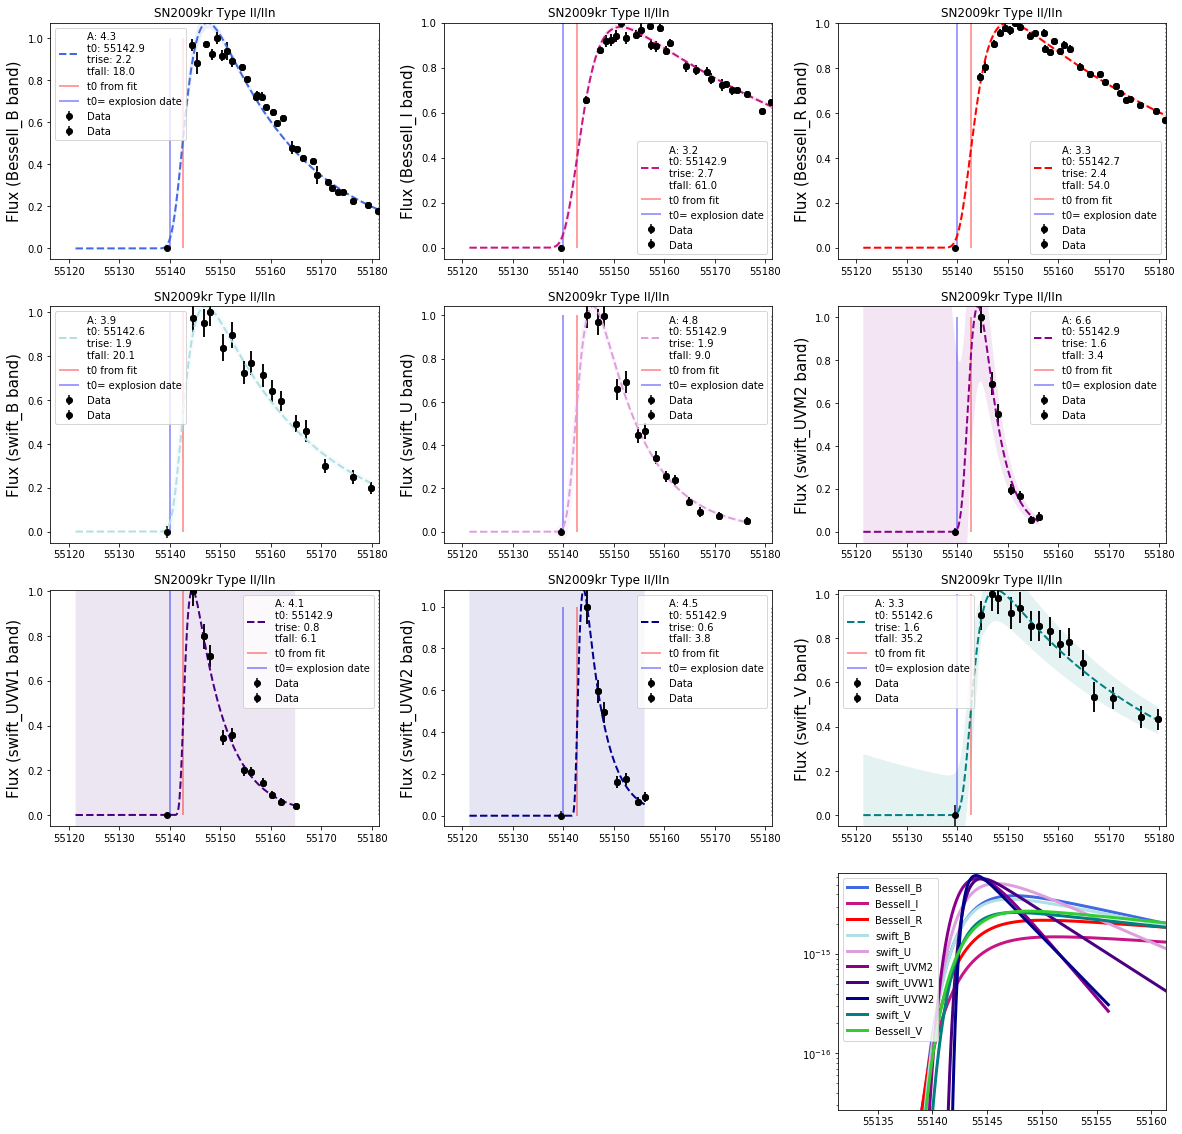

Looking for Photometry for SN2012A in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2012A.dat
Got it!
Photometry loaded


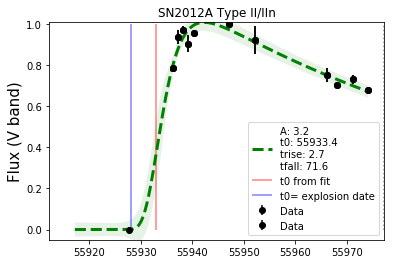

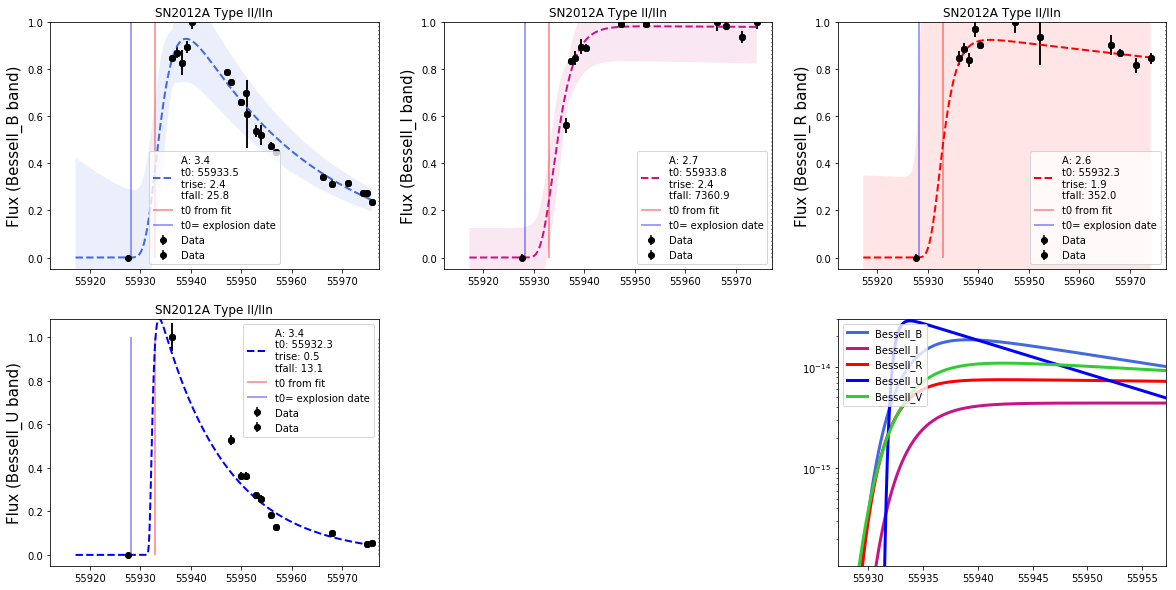

Looking for Photometry for SN2012aw in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2012aw.dat
Got it!
Photometry loaded


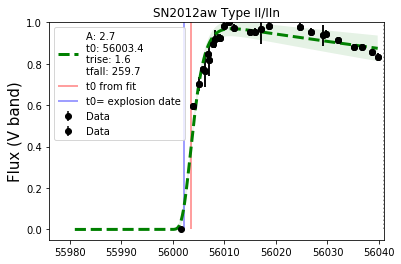

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/pandas/core/nanops.py:465: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values)**2)


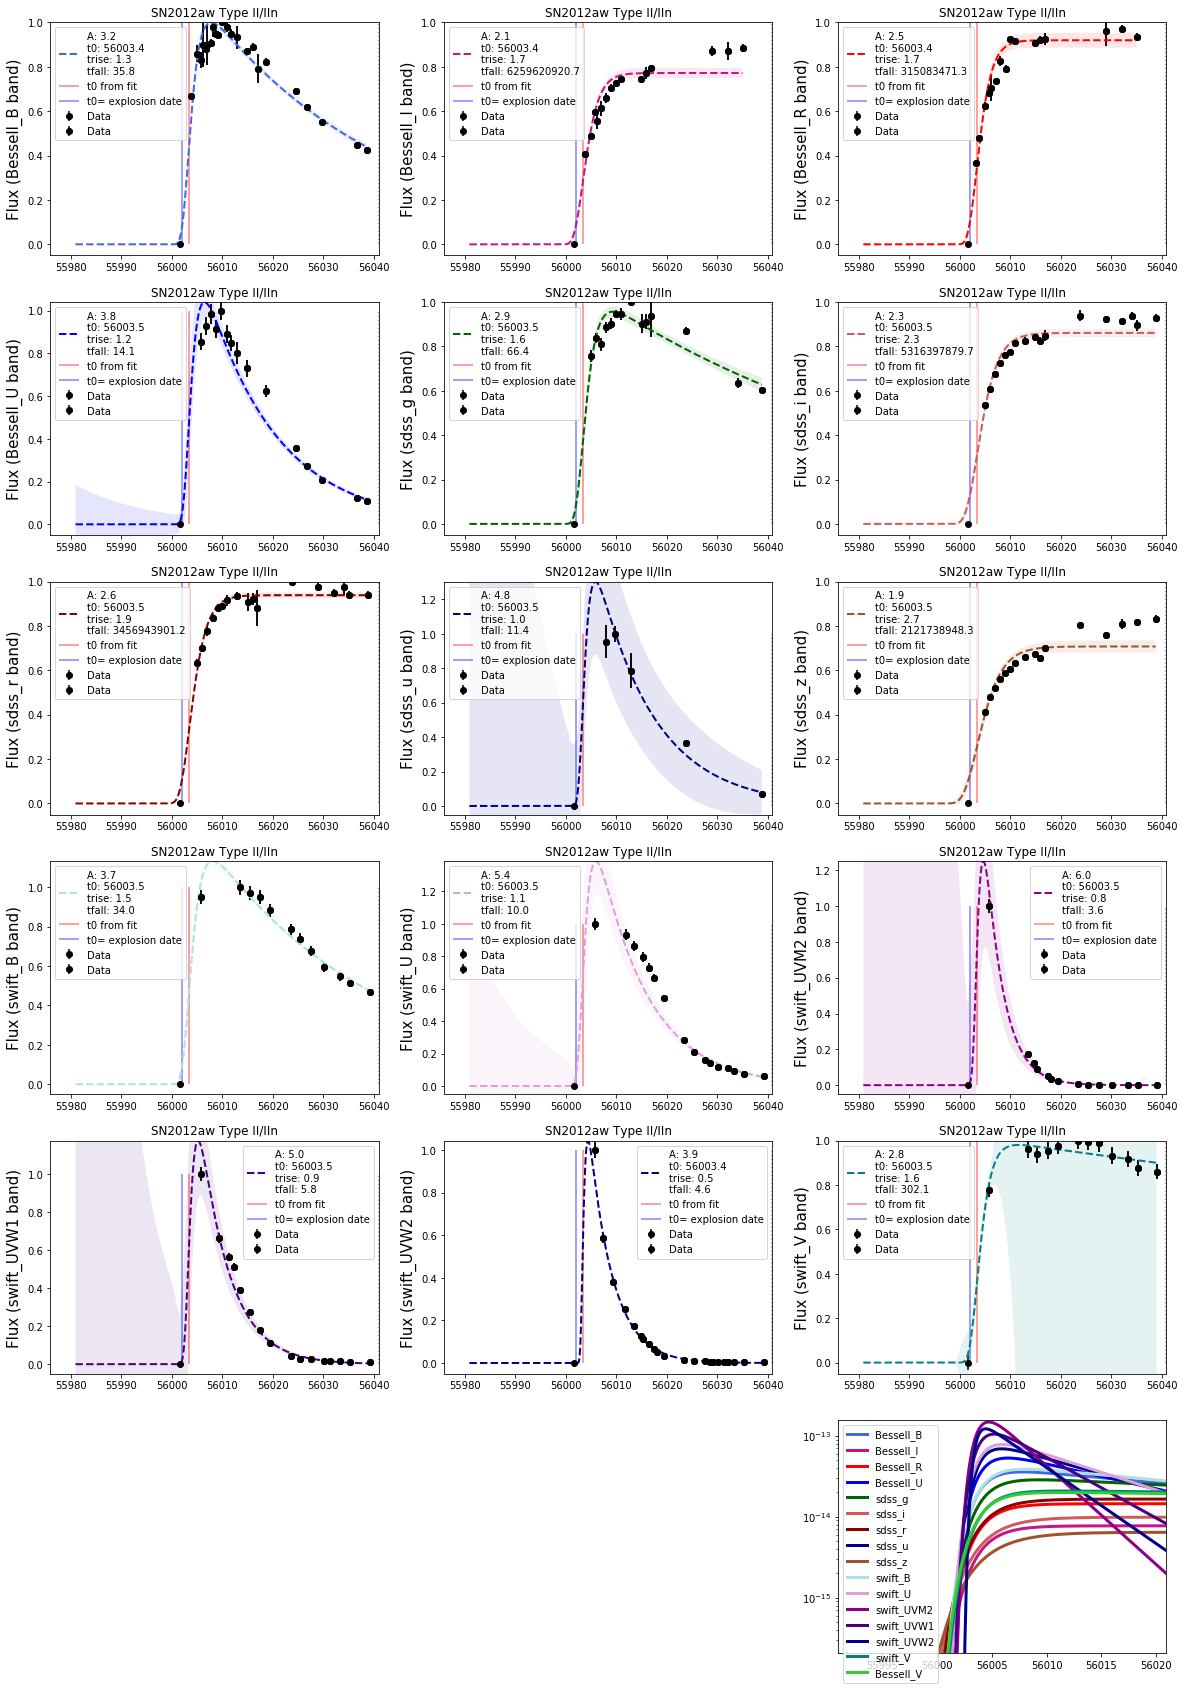

Looking for Photometry for SN2013ab in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2013ab.dat
Got it!
Photometry loaded


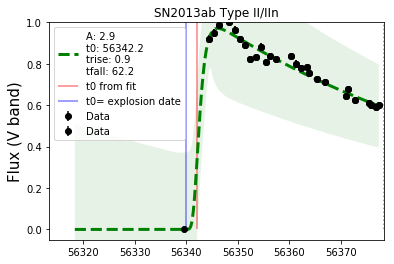

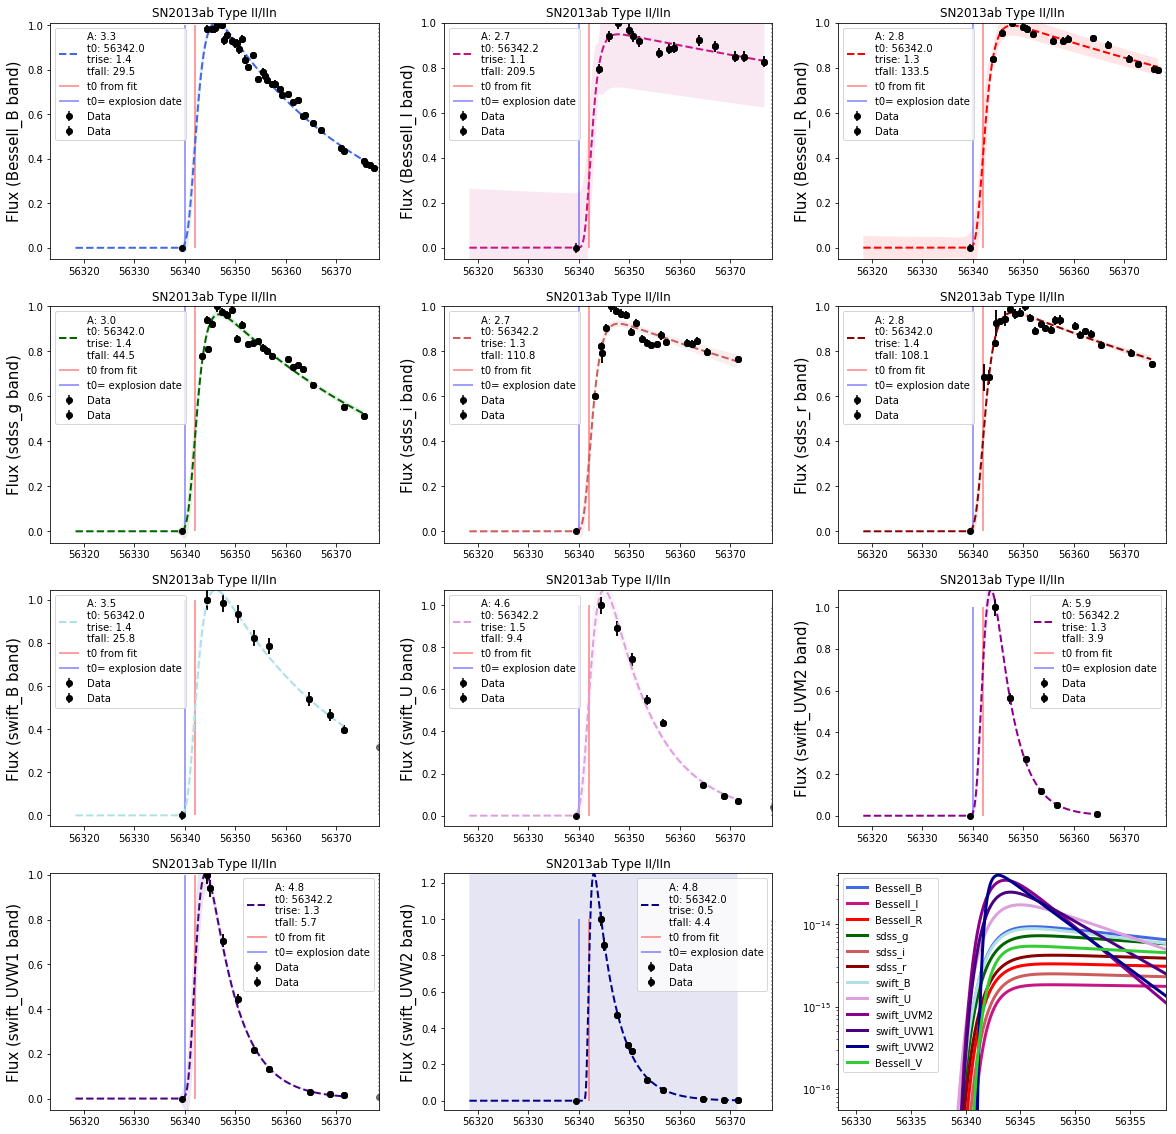

Looking for Photometry for SN2013am in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2013am.dat
Got it!
Photometry loaded


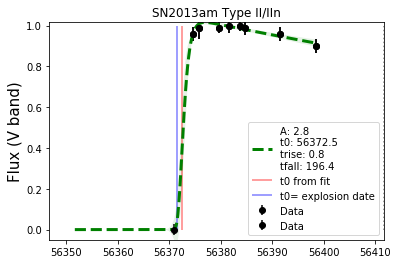

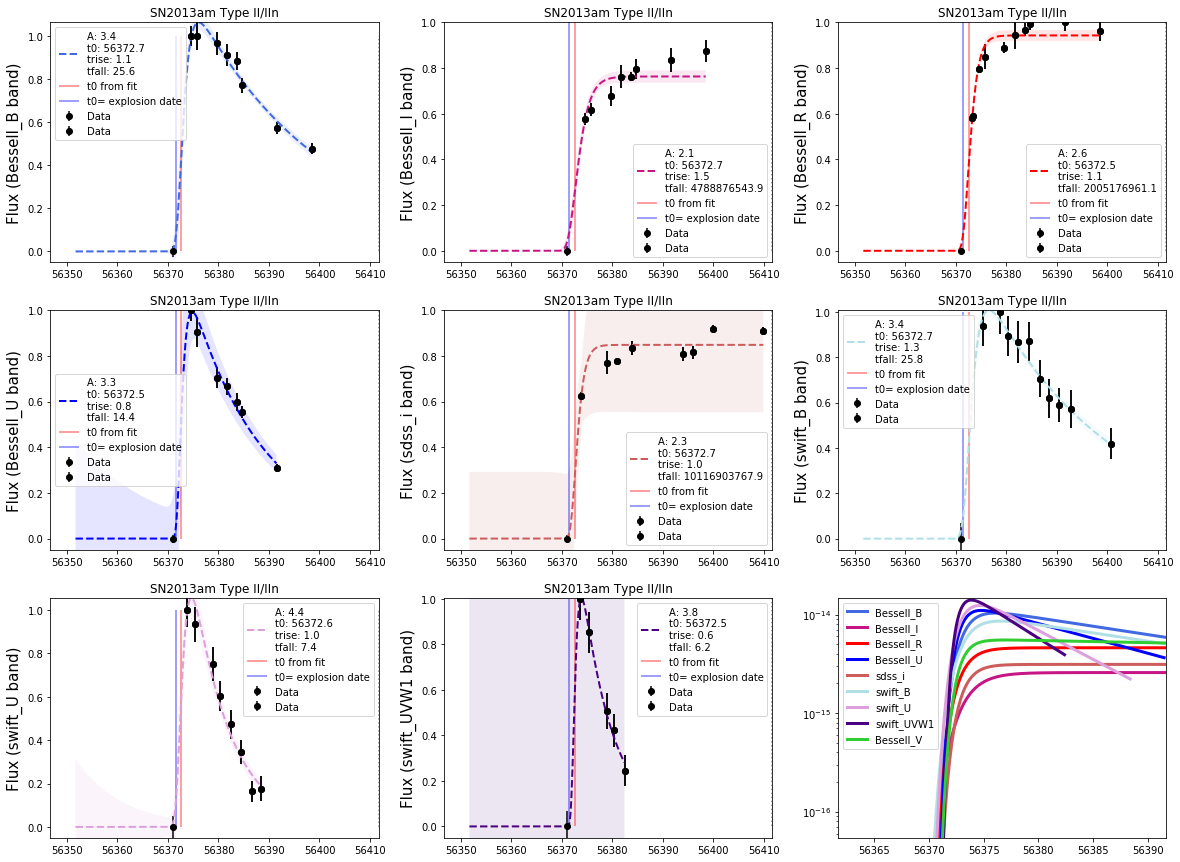

Looking for Photometry for SN2013by in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2013by.dat
Got it!
Photometry loaded


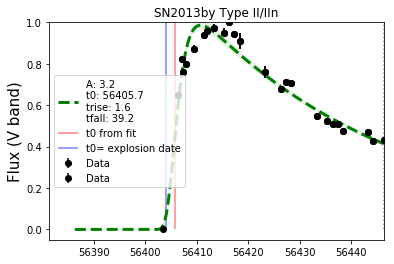

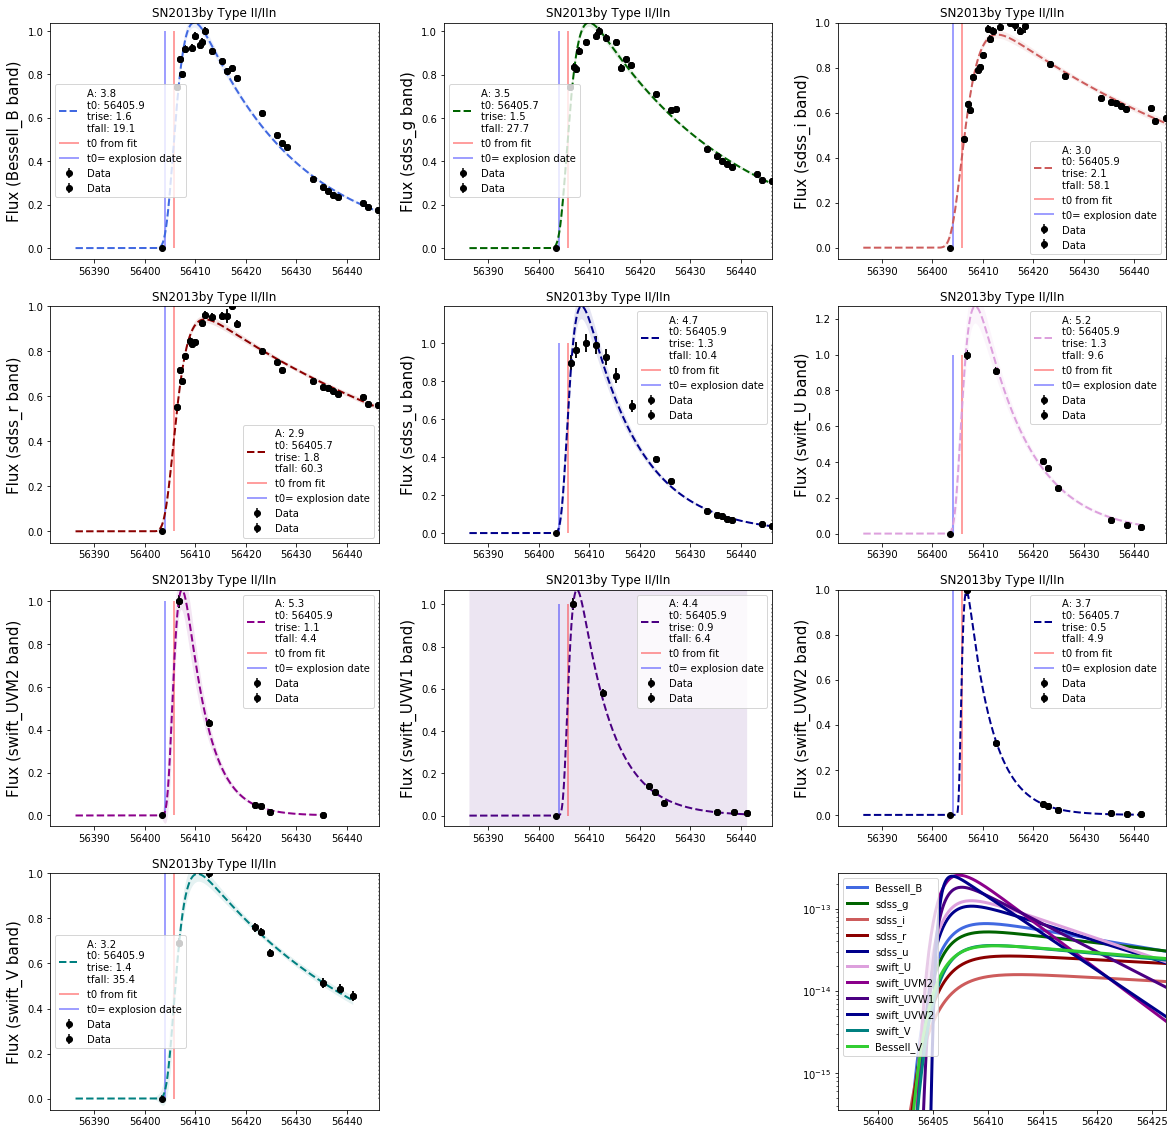

Looking for Photometry for SN2013ej in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2013ej.dat
Got it!
Photometry loaded


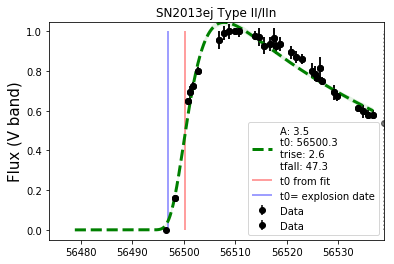

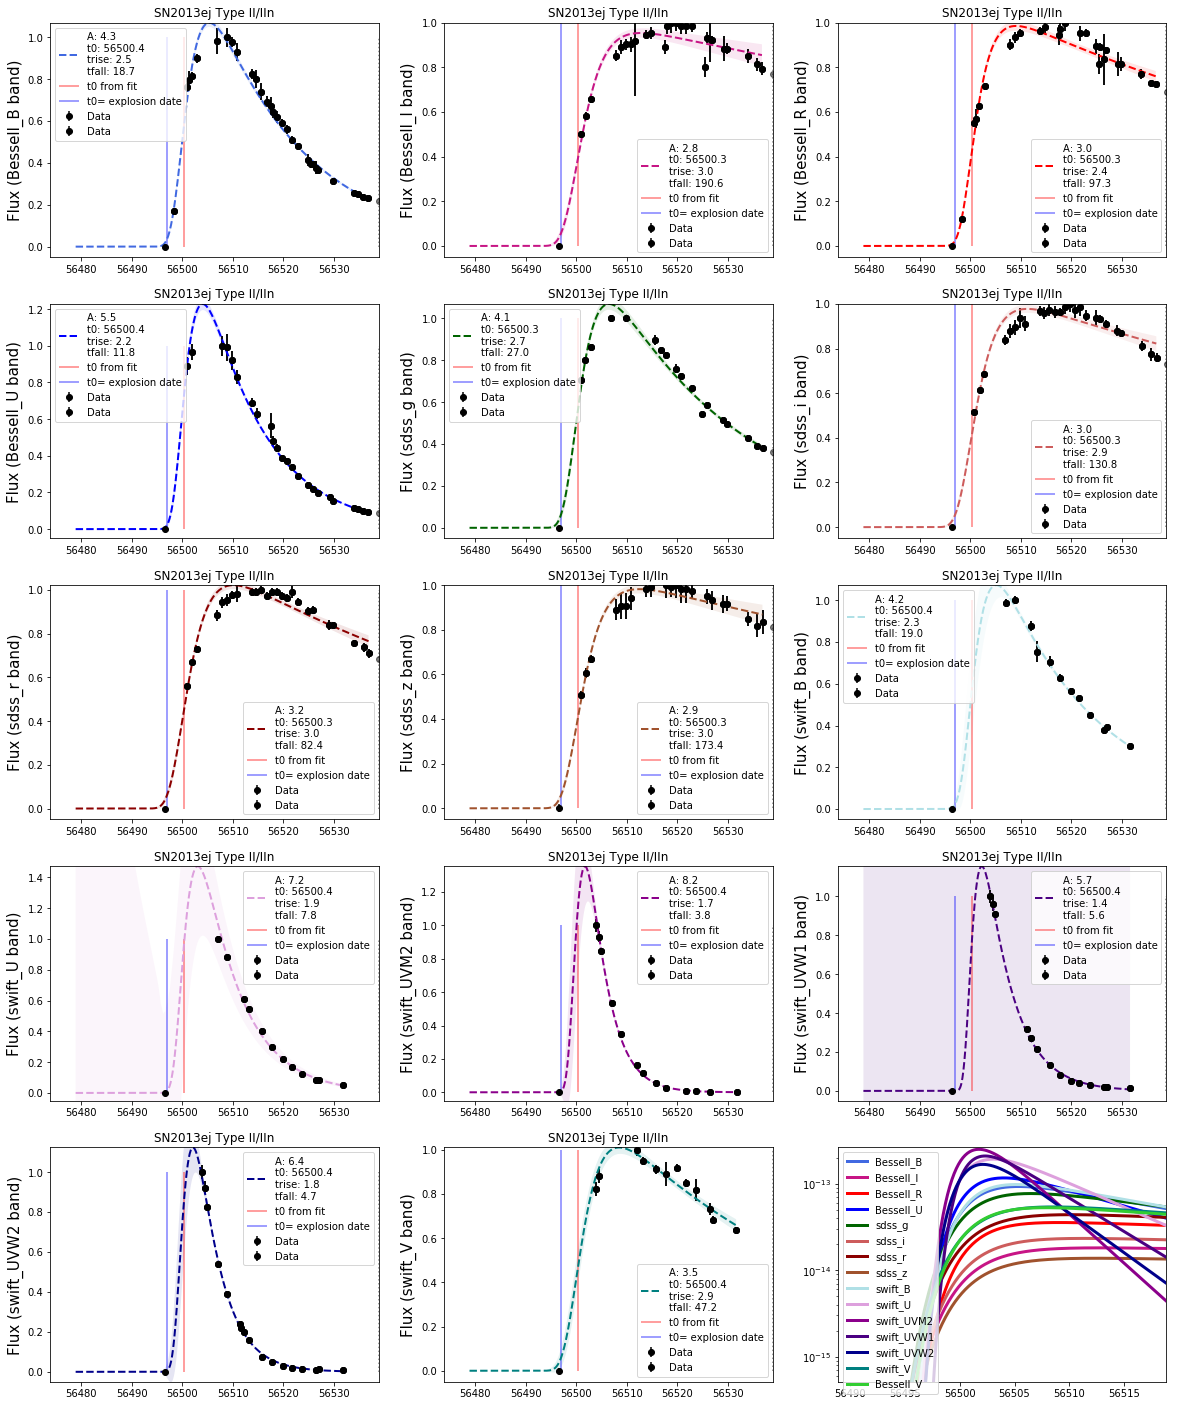

Looking for Photometry for SN2013fs in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2013fs.dat
Got it!
Photometry loaded


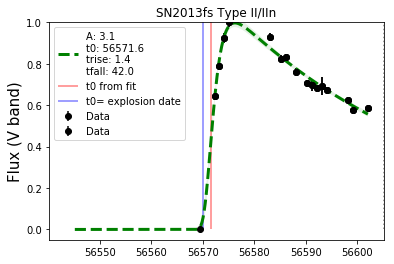

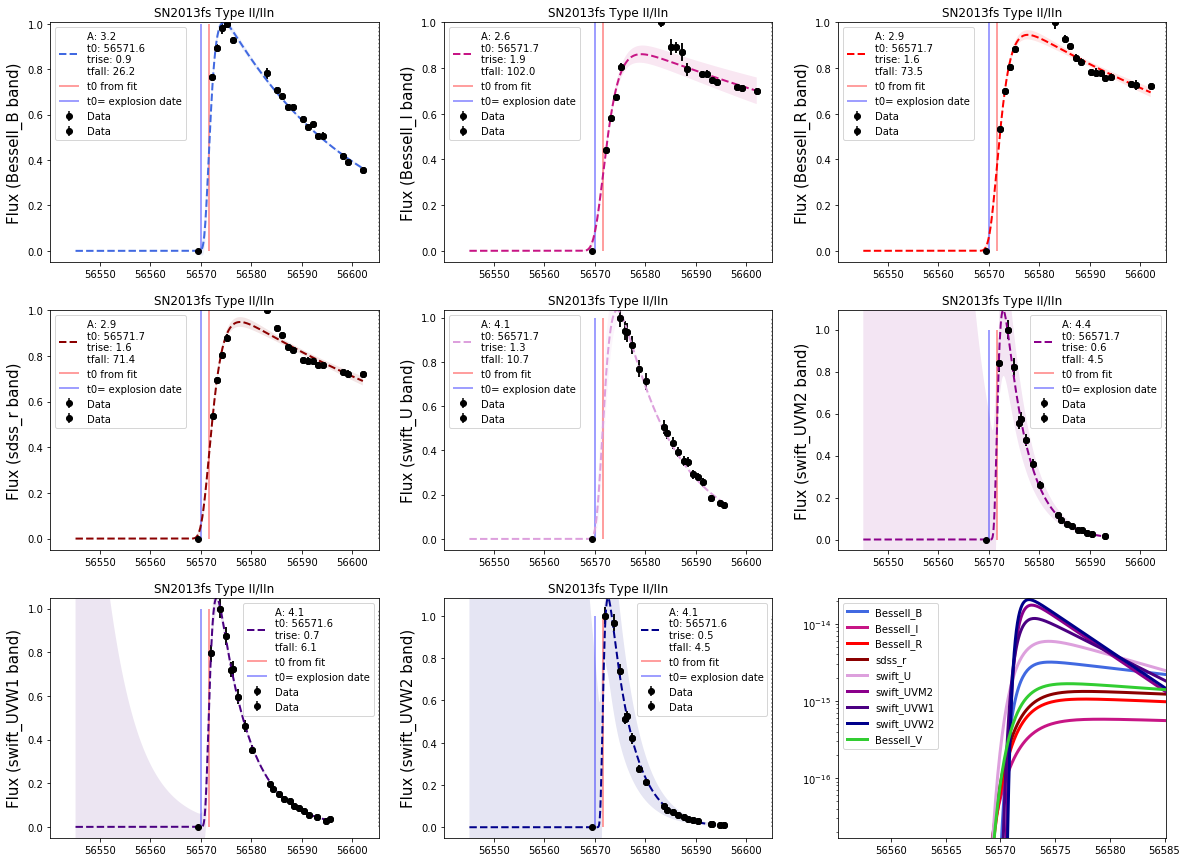

Looking for Photometry for SN2014G in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2014G.dat
Got it!
Photometry loaded


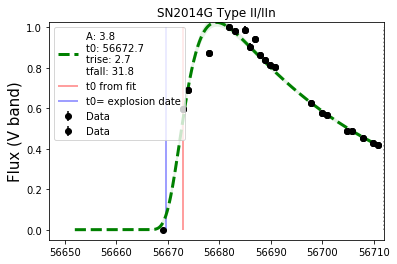

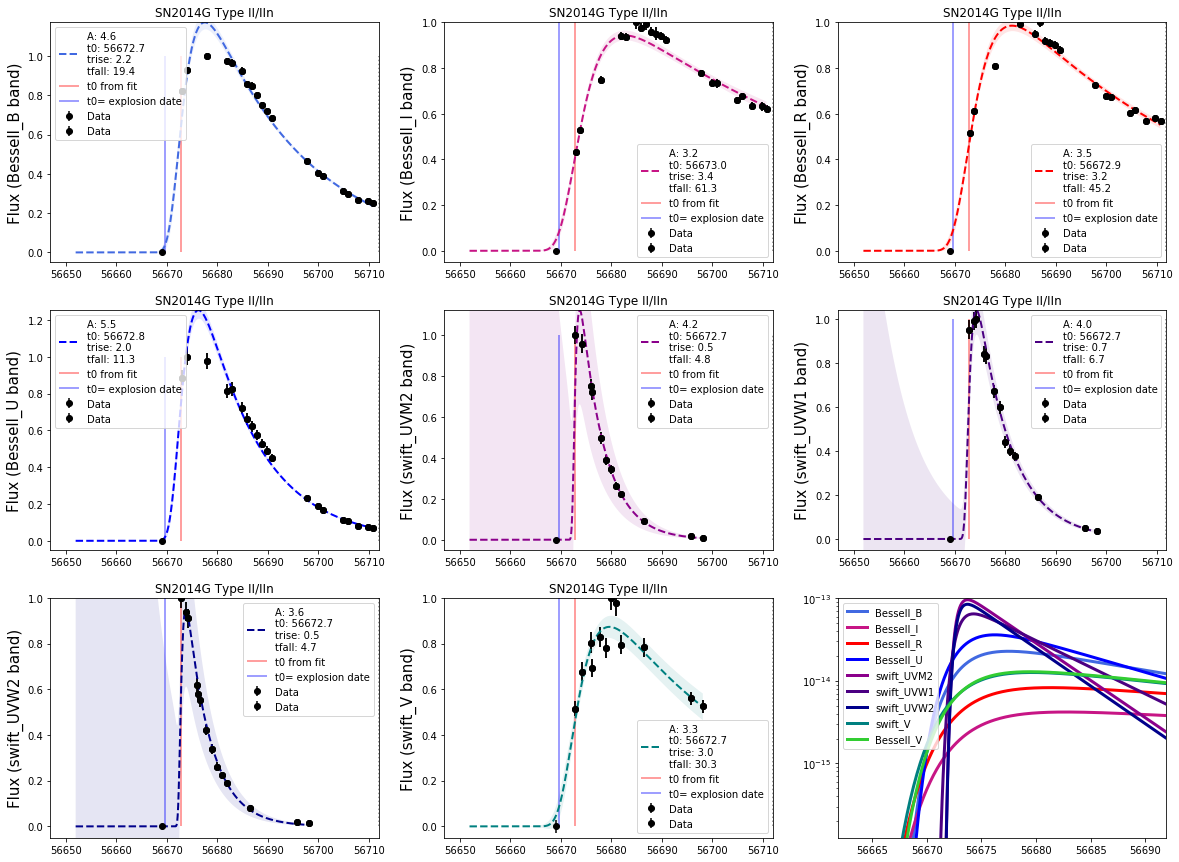

Looking for Photometry for SN2016X in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2016X.dat
Got it!
Photometry loaded


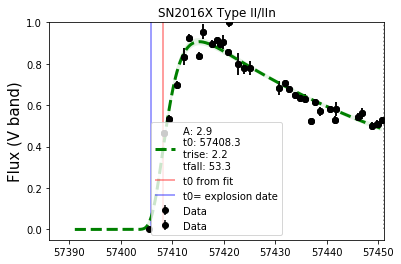

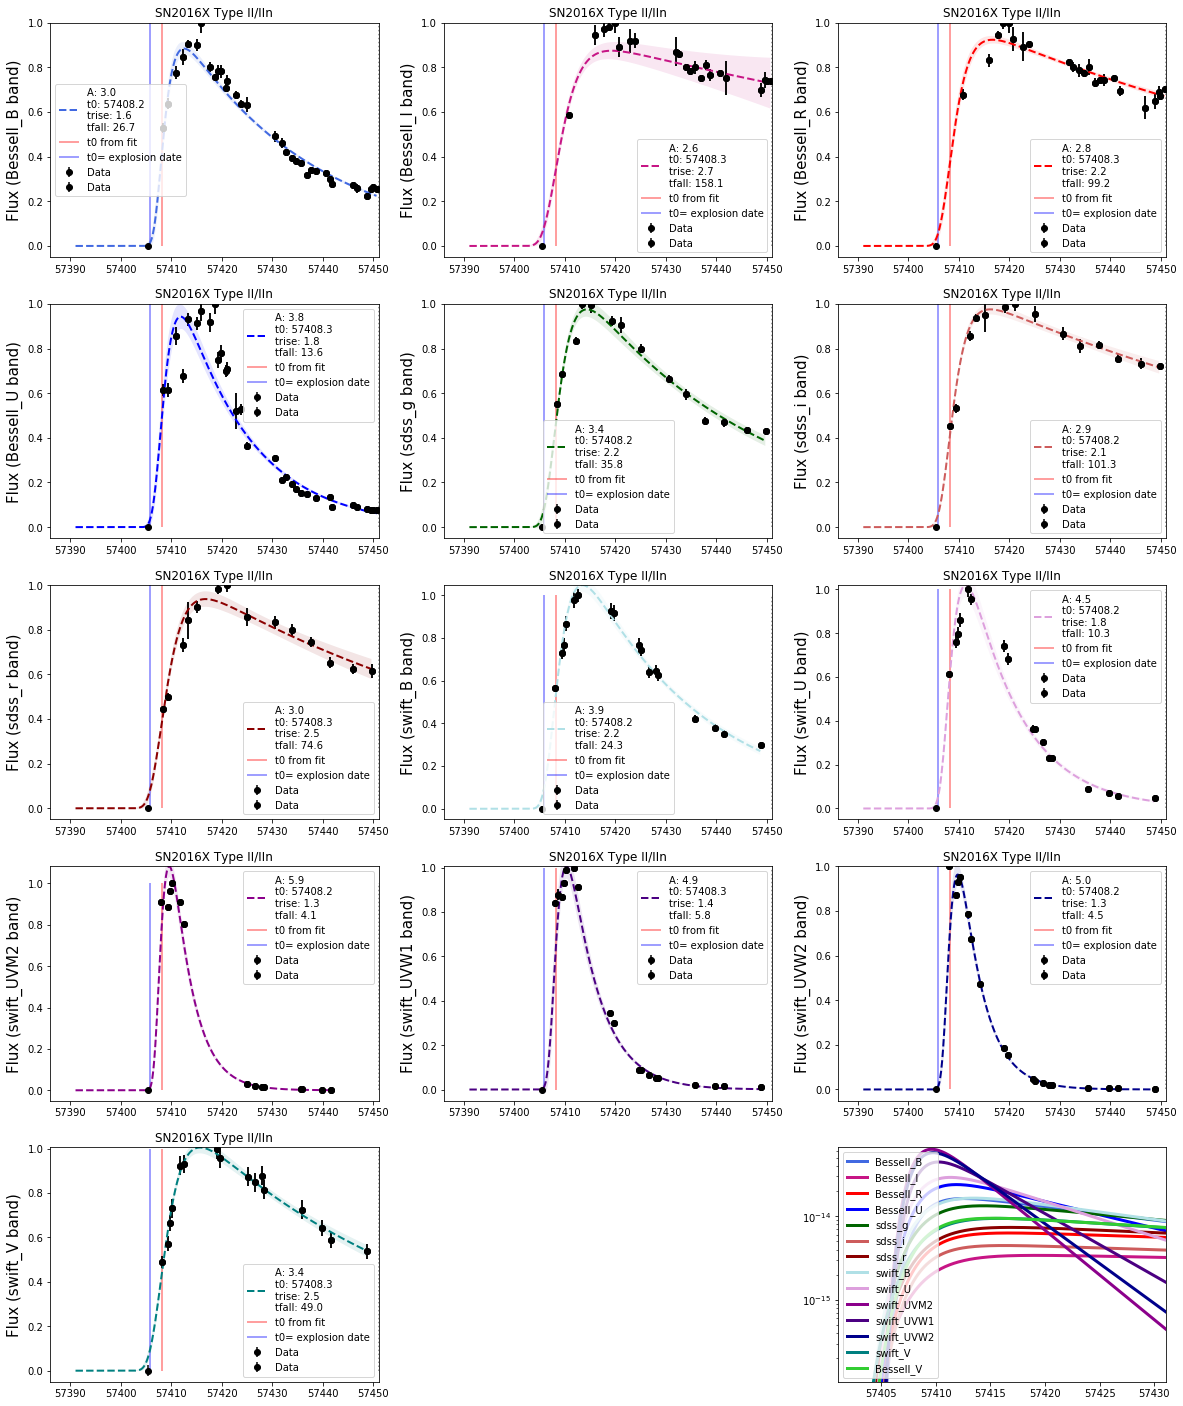

Looking for Photometry for SN2016bkv in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2016bkv.dat
Got it!
Photometry loaded


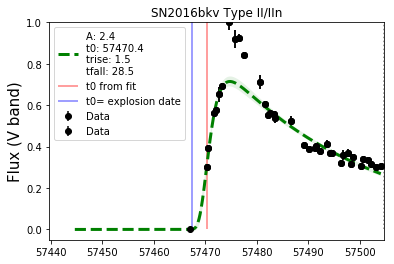

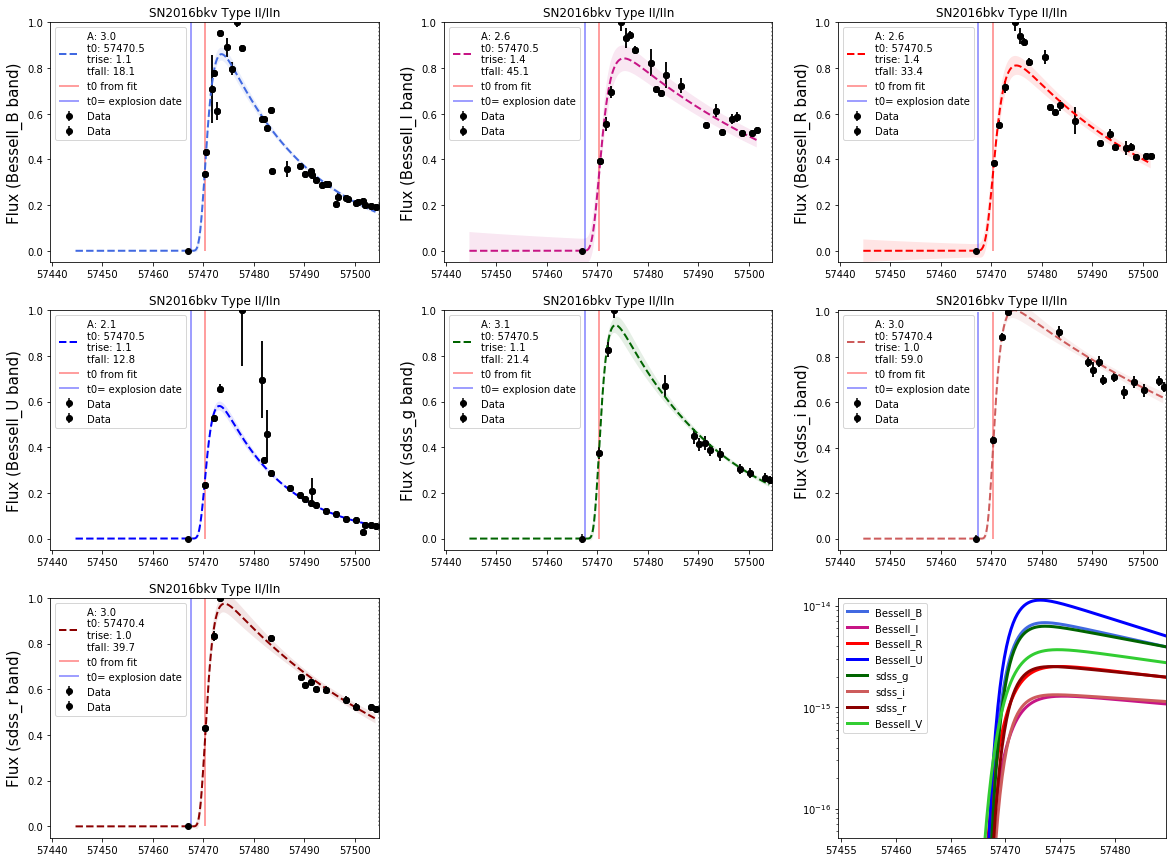

In [117]:
for sn in type_ii:

    SN = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname=sn, verbose=True)
    SN.load()
    SN.get_availfilter()
    SN.clip_photometry(pre_bump= sn in list(pre_bump.keys()))

    lc_file = pd.DataFrame(np.genfromtxt(SN.sn_rawphot_file,
                               names=['MJD','band','Flux','Flux_err','FilterSet', 'Source'], 
                               usecols=[0,1,2,3,4,5], 
                               dtype=None,encoding="utf-8"))
        
    extr_pts_pd = pd.DataFrame().reindex_like(lc_file)[:0]

    # BAND V !!
    band_init = 'Bessell_V' if sn not in ['SN2008aq', 'SN2011ht', 'SN2006aj', 'SN2013ge'] else 'swift_V'
    flux_V = SN.clipped_phot[SN.clipped_phot['filter']==band_init]['flux']
    fluxerr_V = SN.clipped_phot[SN.clipped_phot['filter']==band_init]['flux_err']
    t_V = SN.clipped_phot[SN.clipped_phot['filter']==band_init]['MJD']

    mjd_Vpeak = t_V[np.argmax(flux_V)]
    Vpeak = max(flux_V)

    plt.plot(t_V, flux_V/max(flux_V), 'ok', alpha=0.5)
    
    max_MJD = mjd_Vpeak+30.
    #if sn=='SN2005bf': max_MJD= 53471.
    #if sn=='SN2013ge': max_MJD= 56612.
    #if sn=='SN1999dn': max_MJD= 51417.
    #if sn=='SN2004et': max_MJD= 53280.
    #if sn=='SN2007od': max_MJD= 54411.

    t_ = t_V[t_V<=max_MJD]
    phase_ = t_ - mjd_Vpeak
    flux_ = flux_V[t_V<=max_MJD]/Vpeak
    fluxerr_ = fluxerr_V[t_V<=max_MJD]/Vpeak
    plt.vlines(max_MJD, 0,1, linestyle=':', alpha=0.5)
    
    R, cov, t_extrapV, fittedV, fittedV_err, t_newpts, newpts_, newpts_err, label_dict, success = performe_fit(sn, band_init, t_, flux_, fluxerr_, phase_, mjd_Vpeak)
        
    plt.errorbar(t_, flux_, yerr=fluxerr_, fmt='ok', label='Data')
    plt.ylabel('Flux (V band)', fontsize=15)
            
    plt.plot(t_extrapV, fittedV, 'g--', lw=3, label='\n'.join("%s: %.1f"%(k,v) for (k,v) in label_dict))
    plt.fill_between(t_extrapV, fittedV-fittedV_err, fittedV+fittedV_err,
                     facecolor='g', alpha=0.1)

    plt.errorbar(t_newpts, newpts_, yerr=newpts_err, fmt='r.', ecolor='r', elinewidth=0.2)

    plt.xlim(min(min(t_extrapV)-5., -25.+mjd_Vpeak),30.+mjd_Vpeak)
    if sn in pre_bump.keys(): plt.xlim((explosion_dates[sn][0]-2.),20.+mjd_Vpeak)
    
    if sn in se_sne: plt.title(sn+ '_SESN')
    else: plt.title(sn+ ' Type II/IIn')
    plt.ylim(-0.05, max(1., max(fittedV)))

    plt.legend()
    plt.show()
    
    if success:
        extr_pts_pd['MJD'] = t_newpts
        extr_pts_pd['band'] = np.full(len(t_newpts), fill_value=band_init)
        extr_pts_pd['Flux'] = newpts_*Vpeak
        extr_pts_pd['Flux_err'] = newpts_err*Vpeak
        extr_pts_pd['FilterSet'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
        extr_pts_pd['Source'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
        lc_file = lc_file.append(extr_pts_pd)    
    
    i=1
    early_bands=[]
    exclude_bands = exclude_dict[sn] if sn in exclude_dict else []
    include_bands = include_dict[sn] if sn in include_dict else []

    for band in np.unique(SN.clipped_phot['filter']):
        t_x = SN.clipped_phot[SN.clipped_phot['filter']==band]['MJD']
        #if (min(t_x)<=min(t_V)+0.5)&(len(t_x[t_x<=max_MJD])>=3):
            #if (sn in se_sne)&(band not in [band_init, 'swift_UVW1','swift_UVW2', 'swift_UVM2'])&(band not in exclude_bands):
            #    early_bands.append(band)
            #elif (sn not in se_sne)&(band not in [band_init,'swift_U', 'Bessell_U', 'swift_UVW1',
            #                                   'swift_UVW2', 'swift_UVM2'])&(band not in exclude_bands):
            #    early_bands.append(band)
            #early_bands.append(band)
        #if (band in include_bands):
        #    early_bands.append(band)
        if (len(t_x[t_x<=max_MJD])>=5)&(band!=band_init):
            early_bands.append(band)


    N_rows = int(len(early_bands)/3)+1
    fig = plt.figure(figsize=(20,N_rows*5))
        
    for band in early_bands:
        plt.subplot(N_rows,3,i)
        flux_x = SN.clipped_phot[SN.clipped_phot['filter']==band]['flux']
        fluxerr_x = SN.clipped_phot[SN.clipped_phot['filter']==band]['flux_err']
        t_x = SN.clipped_phot[SN.clipped_phot['filter']==band]['MJD']

        xpeak = max(flux_x)
        plt.plot(t_x, flux_x/xpeak, 'ok', alpha=0.5)
            
        t_ = t_x[t_x<=max_MJD]
        phase_ = t_ - mjd_Vpeak
        flux_ = flux_x[t_x<=max_MJD]/xpeak
        fluxerr_ = fluxerr_x[t_x<=max_MJD]/xpeak
        plt.xlim(min(min(t_extrapV)-5., -25.+mjd_Vpeak),30.+mjd_Vpeak)
        if sn in pre_bump.keys(): plt.xlim((explosion_dates[sn][0]-2.),20.+mjd_Vpeak)

        plt.vlines(max_MJD, 0,1, linestyle=':', alpha=0.5)

        R, cov, t_extrap, fitted, fitted_err, t_newpts, newpts_, newpts_err, label_dict, success  = performe_fit(sn, band, t_, flux_, fluxerr_, phase_, mjd_Vpeak)
        
        plt.errorbar(t_, flux_, yerr=fluxerr_, fmt='ok', label='Data')
        
        plt.ylabel('Flux (%s band)'%band, fontsize=15)
        plt.plot(t_extrap, fitted, '--', color=color_dict[band], lw=2,
                 label='\n'.join("%s: %.1f"%(k,v) for (k,v) in label_dict))
        plt.fill_between(t_extrap, fitted-fitted_err, fitted+fitted_err,
                     facecolor=color_dict[band], alpha=0.1)
        plt.errorbar(t_newpts, newpts_, yerr=newpts_err, fmt='r.', ecolor='r', elinewidth=0.2)
        plt.ylim(-0.05, max(1., max(fitted)))
        
        if sn in se_sne: plt.title(sn+ '_SESN')
        else: plt.title(sn+ ' Type II/IIn')
        plt.legend()
        i=i+1
   
        if success:
            extr_pts_pd = pd.DataFrame().reindex_like(lc_file)[:0]
            extr_pts_pd['MJD'] = t_newpts
            extr_pts_pd['band'] = np.full(len(t_newpts), fill_value=band)
            extr_pts_pd['Flux'] = newpts_ * xpeak
            extr_pts_pd['Flux_err'] = newpts_err * xpeak
            extr_pts_pd['FilterSet'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
            extr_pts_pd['Source'] = np.full(len(t_newpts), fill_value='SUDO_PTS')
            lc_file = lc_file.append(extr_pts_pd)    
            plt.subplot(N_rows,3,N_rows*3)
            plt.plot(t_extrap, fitted*xpeak, '-', color=color_dict[band], lw=3,
                 label=band)
            #plt.fill_between(t_extrap, (fitted-fitted_err)*xpeak, (fitted+fitted_err)*xpeak,
            #         facecolor=color_dict[band], alpha=0.1)
    plt.subplot(N_rows,3,N_rows*3)
    plt.plot(t_extrapV, fittedV*Vpeak, '-', color=color_dict['Bessell_V'], lw=3,
                 label='Bessell_V')
    #plt.fill_between(t_extrapV, Vpeak*(fittedV-fittedV_err), Vpeak*(fittedV+fittedV_err),
    #                 facecolor=color_dict[band], alpha=0.1)
    plt.xlim( -20.+mjd_Vpeak, 10.+mjd_Vpeak)
    plt.ylim(Vpeak*10**-2,None)
    plt.legend(loc = 'upper left')
    plt.yscale('log')
    plt.show()
    plt.close(fig)
    

In [99]:
trise_typeII

[('ASASSN14jb',
  1.2195959486968664,
  'Bessell_V',
  56946.1,
  56948.27,
  0.15,
  56954.14),
 ('ASASSN14jb',
  1.7175426933349223,
  'Bessell_B',
  56946.1,
  56948.27,
  0.15,
  56954.14),
 ('ASASSN14jb',
  1.2195959486968664,
  'Bessell_V',
  56946.1,
  56948.27,
  0.15,
  56954.14),
 ('ASASSN14jb',
  0.8930234417154479,
  'sdss_g',
  56946.1,
  56948.27,
  0.15,
  56954.14),
 ('ASASSN14jb',
  2.5008522043352763,
  'sdss_i',
  56946.1,
  56948.27,
  0.15,
  56954.14),
 ('ASASSN14jb',
  1.9709509676091592,
  'sdss_r',
  56946.1,
  56948.27,
  0.15,
  56954.14),
 ('ASASSN14jb',
  1.5885260387082634,
  'swift_B',
  56946.1,
  56948.27,
  0.15,
  56954.14),
 ('ASASSN14jb',
  1.5534229490244371,
  'swift_U',
  56946.1,
  56948.27,
  0.15,
  56954.14),
 ('ASASSN14jb',
  1.1739404672493323,
  'swift_UVM2',
  56946.1,
  56948.27,
  0.15,
  56954.14),
 ('ASASSN14jb',
  1.295864670060278,
  'swift_UVW1',
  56946.1,
  56948.27,
  0.15,
  56954.14),
 ('ASASSN14jb',
  0.40000000000000185,
  '

In [100]:
len(trise_typeII)

549

In [101]:
plt.plot(t_, flux_, 'o')
def Bazin(t, A, t0, tfall, trise):
    up = np.exp( -(t-t0)/(tfall) )
    down = np.exp( 1.+ np.exp( (t-t0)/(trise) ))
    return A*up/down

p0 =[4.2,explosion_dates['SN2016gkg'][0]+31., 6.8,-15.]
bounds=([0.,explosion_dates['SN2016gkg'][0]-40.,2., -40.],
        [10.,explosion_dates['SN2016gkg'][0]+40.,np.inf, 1.])   

plt.plot(t_, Bazin(t_, *p0))2
        

SyntaxError: invalid syntax (<ipython-input-101-21c3ca3c0560>, line 11)

In [48]:
D_to['SN2014G'], D_to_err['SN2014G'], 

([56672.68842244951,
  56672.95712433567,
  56673.5321108209,
  56672.86858314175,
  2253171.3351344555,
  56672.68842244951,
  56560.18438042427,
  56542.85266184238,
  56563.294779596814,
  56672.330030863355],
 [0.17484535465293816,
  nan,
  0.269867014567943,
  0.22835614701298584,
  97114275730780.8,
  0.17484535465293816,
  26987943250.559303,
  inf,
  0.0,
  0.46531802193293864])

In [28]:
D_to={}
D_to_err={}


for sn,trise,filt,texp,t0_fit,t0_fit_err,tmax in trise_typeII:
    D_to[sn] = []
    D_to_err[sn] = []


for sn,trise,filt,texp,t0_fit,t0_fit_err,tmax in trise_typeII:
    D_to[sn] = D_to[sn] + [t0_fit]
    D_to_err[sn] = D_to_err[sn] + [t0_fit_err]


In [52]:
for sn in D_to.keys():
    mask_inf_nan = np.array((~np.isnan(D_to_err[sn]))&(~np.isinf(D_to_err[sn]))&(np.array(D_to_err[sn])>0.))
    data = np.array(D_to[sn])[mask_inf_nan]
    weights = 1./np.array(D_to_err[sn])[mask_inf_nan]
    avg, sum_w = np.average(data, weights=weights, returned=True)
    print ('"%s"'%sn, ':(%.2f , %.2f),'%(avg, 1./sum_w))

"SN2006T" :(53775.33 , 0.14),
"SN2016X" :(57408.22 , 0.02),
"SN2011hs" :(55882.78 , 0.09),
"SN2011ht" :(55875.16 , 0.55),
"SN2004gt" :(53354.58 , 0.07),
"SN2005hg" :(53677.11 , 0.16),
"SN2008ax" :(54541.15 , 0.11),
"SN2007Y" :(54157.12 , 0.14),
"SN2013fs" :(56571.63 , 0.02),
"SN2016bkv" :(57470.43 , 0.01),
"ASASSN15oz" :(57264.76 , 0.09),
"SN2013ej" :(56500.31 , 0.02),
"SN2007od" :(54407.69 , 0.15),
"SN2013am" :(56372.57 , 0.04),
"SN2009dd" :(54931.45 , 0.22),
"SN2008in" :(54826.90 , 0.71),
"SN2004gv" :(53359.84 , 0.16),
"SN2013by" :(56405.77 , 0.03),
"SN2014G" :(56672.83 , 0.05),
"SN2007ru" :(54435.30 , 0.07),
"SN2009ip" :(56198.67 , 0.07),
"iPTF13bvn" :(56469.88 , 0.13),
"SN1998bw" :(50939.86 , 0.19),
"SN1999em" :(51478.55 , 0.23),
"SN2013ab" :(56342.08 , 0.04),
"SN2012A" :(55933.02 , 0.25),
"SN2016gkg" :(57662.76 , 0.20),
"SN2006ep" :(53980.72 , 0.11),
"SN2011bm" :(55662.00 , 0.12),
"SN2009N" :(54852.54 , 0.26),
"SN2013ge" :(56611.77 , 0.19),
"SN2008bo" :(54559.75 , 0.23),
"SN2009bb

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [36]:
(~np.isnan(D_to_err['ASASSN15oz']))&(~np.isinf(D_to_err['ASASSN15oz']))

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True, False,  True])

In [38]:
D_trise_typeII={}
D_tmax_typeII={}
D_tfit_typeII={}


for trise,filt,texp,t0_fit,tmax in trise_typeII:
    f = filt.replace('swift_', '').replace('Bessell_', '').replace('sdss_', '').replace("'", '').upper()
    D_trise_typeII[f] = []
    D_tmax_typeII[f] = []
    D_tfit_typeII[f] = []


for trise,filt,texp,t0_fit,tmax in trise_typeII:
    f = filt.replace('swift_', '').replace('Bessell_', '').replace('sdss_', '').replace("'", '').upper()
    D_trise_typeII[f] = D_trise_typeII[f] + [trise]
    D_tmax_typeII[f] = D_tmax_typeII[f] + [texp-tmax]
    D_tfit_typeII[f] = D_tfit_typeII[f] + [texp-t0_fit]



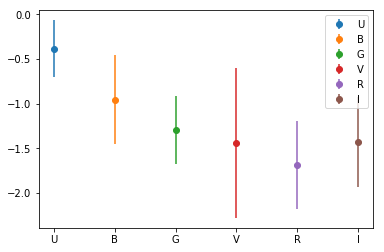

In [42]:
for f in ['U', 'B','G','V', 'R', 'I']:
    plt.errorbar(f, np.median(D_trise_typeII[f]), yerr=np.std(D_trise_typeII[f]), fmt='o', label=f)
plt.legend()

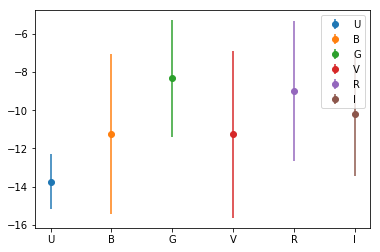

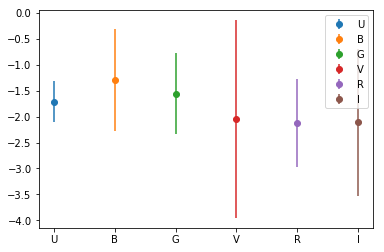

In [43]:
for f in ['U', 'B','G','V', 'R', 'I']:
    plt.errorbar(f, np.median(D_tmax_typeII[f]), yerr=np.std(D_tmax_typeII[f]), fmt='o', label=f)
plt.legend()
plt.show()

for f in ['U', 'B','G','V', 'R', 'I']:
    plt.errorbar(f, np.median(D_tfit_typeII[f]), yerr=np.std(D_tfit_typeII[f]), fmt='o', label=f)
plt.legend()
plt.show()



# MEGA fit

In [257]:
for sn in ['SN2016gkg']:

    SN = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname=sn, verbose=True)
    SN.load()
    SN.get_availfilter()
    SN.clip_photometry(pre_bump= sn in list(pre_bump.keys()))

    lc_file = pd.DataFrame(np.genfromtxt(SN.sn_rawphot_file,
                               names=['MJD','band','Flux','Flux_err','FilterSet', 'Source'], 
                               usecols=[0,1,2,3,4,5], 
                               dtype=None,encoding="utf-8"))
        
    extr_pts_pd = pd.DataFrame().reindex_like(lc_file)[:0]

    # BAND V !!
    band_init = 'Bessell_V' if sn not in ['SN2008aq', 'SN2011ht', 'SN2006aj', 'SN2013ge'] else 'swift_V'
    flux_V = SN.clipped_phot[SN.clipped_phot['filter']==band_init]['flux']
    fluxerr_V = SN.clipped_phot[SN.clipped_phot['filter']==band_init]['flux_err']
    t_V = SN.clipped_phot[SN.clipped_phot['filter']==band_init]['MJD']

    mjd_Vpeak = t_V[np.argmax(flux_V)]
    Vpeak = max(flux_V)
    
    max_MJD = mjd_Vpeak+20.
    if sn=='SN2005bf': max_MJD= 53471.
    if sn=='SN2013ge': max_MJD= 56612.
    if sn=='SN1999dn': max_MJD= 51417.
    if sn=='SN2004et': max_MJD= 53280.
    if sn=='SN2007od': max_MJD= 54411.

    t_ = t_V[t_V<=max_MJD]
    phase_ = t_ - mjd_Vpeak
    flux_ = flux_V[t_V<=max_MJD]/Vpeak
    fluxerr_ = fluxerr_V[t_V<=max_MJD]/Vpeak

    early_bands=[]
    exclude_bands = exclude_dict[sn] if sn in exclude_dict else []
    include_bands = include_dict[sn] if sn in include_dict else []

    f_t_matrix = [np.zeros(len(t)) for i in range(N)]

    A_str_list = []
    tfall_str_list = []
    trise_str_list = []
    A_str_list.append('t0')
    t0=explosion_dates[sn][0]
    N=0
    for band in np.unique(SN.clipped_phot['filter']):
        t_x = SN.clipped_phot[SN.clipped_phot['filter']==band]['MJD']
        if (len(t_x)>=20):
            early_bands.append(band)
            #A_str_list.append('A_'+band)
            tfall_str_list.append('tfall_'+band)
            trise_str_list.append('trise_'+band)
            A_str_list.append('A_%s, tfall_%s, trise_%s'%(band,band,band))
            exec('A_%s=1.; tfall_%s=20.; trise_%s=-5.'%(band,band,band))
            N=N+1


Looking for Photometry for SN2016gkg in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2016gkg.dat
Got it!
Photometry loaded


In [258]:
def Bazin(t, t0, A, tfall, trise):
    up = np.exp( -(t-t0)/(tfall) )
    down = np.exp( 1.+ np.exp( (t-t0)/(trise) ))
    return A*up/down

def Bazin_mega_fit(t, A_args):
    f_t_matrix = [np.zeros(len(t)) for i in range(N)]
    for i,A in zip(np.arange(-1,N,1), A_args):
        if i==-1: t0=A; print (t0)
        else: 
            #print (f_t_matrix[i], A) 
            f_t_matrix[i] = Bazin(t,t0, *A)
    return f_t_matrix

In [259]:
res = Bazin_mega_fit(t_, map(eval, A_str_list))
#Bazin_mega_fit(map(eval, A_str_list), map(eval, tfall_str_list), map(eval, tfall_str_list))

57651.0


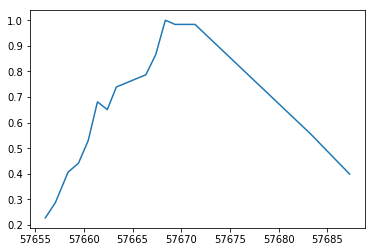

In [260]:
plt.plot(t_, flux_)

In [263]:
R,cov = opt.curve_fit(Bazin_mega_fit, t_, flux_)

TypeError: zip argument #2 must support iteration

In [ ]:
def Bazin_mega_fit(t, *args):
    up = np.exp( -(t-t0)/(tfall) )
    down = np.exp( 1.+ np.exp( (t-t0)/(trise) ))
    return A*up/down

        #p0 =[1.6,t0_fix,-8.]
        #bounds=([0.,t0_fix-20., -40.],[10.,t0_fix+20., 1.])   
        p0 =[1.6, 50.,-8.]#p0 =[1.6,t0_fix+2., 50.,-8.]
        bounds=([0.,2., -40.],[10.,np.inf, 1.])#bounds=([0.,t0_fix-40.,2., -40.],[10.,t0_fix+40.,np.inf, 1.])   

    elif (~isinstance(t0_fix, float)):
        #names=['A', 't0', 'trise']
        #def Bazin(t, A, t0, trise):
        #    down = np.exp( 1.+ np.exp( (t-t0)/(trise) ))
        #    return A/down
        names=['A', 't0', 'tfall', 'trise']
        def Bazin(t, A, t0, tfall, trise):
            up = np.exp( -(t-t0)/(tfall) )
            down = np.exp( 1.+ np.exp( (t-t0)/(trise) ))
            return A*up/down

        #p0 = [1.6,mjd_Vpeak,-8.]
        #bounds=([0.,mjd_Vpeak-20., -40.],[10.,mjd_Vpeak+20., 1.])   
        p0 =[1.6,mjd_Vpeak, 50.,-8.]
        #bounds=([0.,mjd_Vpeak-40.,2., -40.],[10.,mjd_Vpeak+40.,np.inf, 1.])   

    else:
        pass
    
    plt.errorbar(t_, flux_, yerr=fluxerr_, fmt='ok', label='Data')

    R,cov = opt.curve_fit(Bazin, t_, flux_, p0=p0, #bounds=bounds,
                        sigma=fluxerr_, maxfev=10000)
        
    explos_day = 57658.#R[np.array(names)=='t0'][0]
    plt.vlines(explos_day, 0,1, color='r', linestyle='-', alpha=0.5, label='t0 from fit')
    plt.vlines(t0_fix, 0,1, color='b', linestyle='-', alpha=0.5, label='t0= explosion date')

        
    dT = 0.25 if sn not in pre_bump.keys() else 0.1    
    t_newpts = np.arange(explos_day+0.05, min(t_), dT)
    t_extrap = np.arange(min(explos_day-5., -30.+mjd_Vpeak), max(phase_)+mjd_Vpeak,0.1)

    if np.any(np.isinf(cov)): 
        print ('#######################'+'COVARIANCE MATRIX inf')
        fit_ = Bazin(t_extrap, *R)
        fit_err = 0.2*fit_#np.zeros(len(fit_))

        newpts_ = Bazin(t_newpts, *R)
        newpts_err = 0.2*newpts_ #np.zeros(len(newpts_))
        success=True
    else:
        rand = np.random.multivariate_normal(R, cov, size=10000)
    
        fit_ = Bazin(t_extrap, *R)
        fit_err = pd.DataFrame(Bazin(t_extrap, *par) for par in rand).std().values

        newpts_ = Bazin(t_newpts, *R)
        newpts_err = pd.DataFrame(Bazin(t_newpts, *par) for par in rand).std().values
        success=True

    trise_typeII.append((R[np.array(names)=='trise'][0],filt, explosion_dates[sn][0], explos_day, mjd_Vpeak))

    return R, cov, t_extrap, fit_, fit_err, t_newpts, newpts_, newpts_err, dict(zip(names, np.round(R,1))).items() , success






## OTHERS test for CODEs

In [182]:
def old_fit(x, a, n, b, t_bump, sig):
    t0=11.
    f_t = np.zeros(len(x))
    f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))
    return f_t 
def fit(x, a, n, b, t_bump, sig):
    t0=11.
    f_t = np.zeros(len(x))
    f_t[x>t0] = a * (x[x>t0]-t0)**n + b*np.exp(-np.power(x[x>t0] - t_bump, 2.) / (2 * np.power(sig, 2.)))*(1.-np.exp(-(x[x>t0]-11.)))
    return f_t    

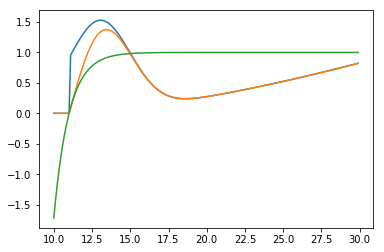

In [158]:
time = np.arange(10.,30.,0.1)
plt.plot(time, old_fit(time, 0.01, 1.5, 1.5, 13.,2. ))
plt.plot(time, fit(time, 0.01, 1.5, 1.5, 13.,2. ))
plt.plot(time, 1.-np.exp(-(time-11.)))



0.3000284641729728

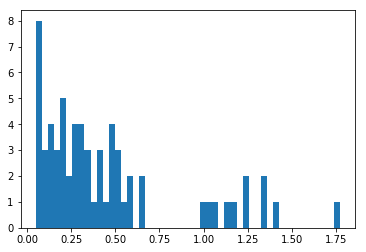

In [386]:
plt.hist(n_hydr_avg, bins=50)
np.median(n_hydr_avg)

### Try NOT to fix n or explosion date and see what happend

Looking for Photometry for SN2016X in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2016X.dat
Got it!
Photometry loaded


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Looking for Photometry for SN2016gkg in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2016gkg.dat
Got it!
Photometry loaded


Looking for Photometry for SN2016bkv in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2016bkv.dat
Got it!
Photometry loaded


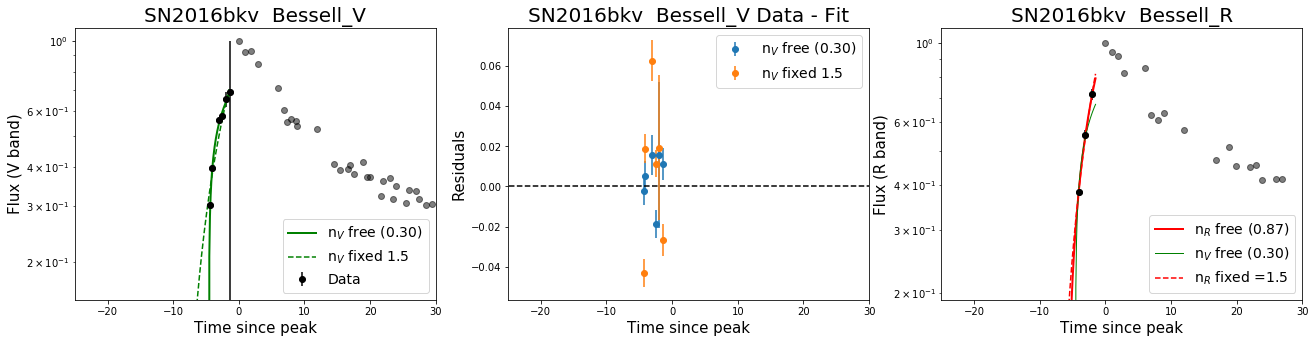

Looking for Photometry for SN2014G in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2014G.dat
Got it!
Photometry loaded


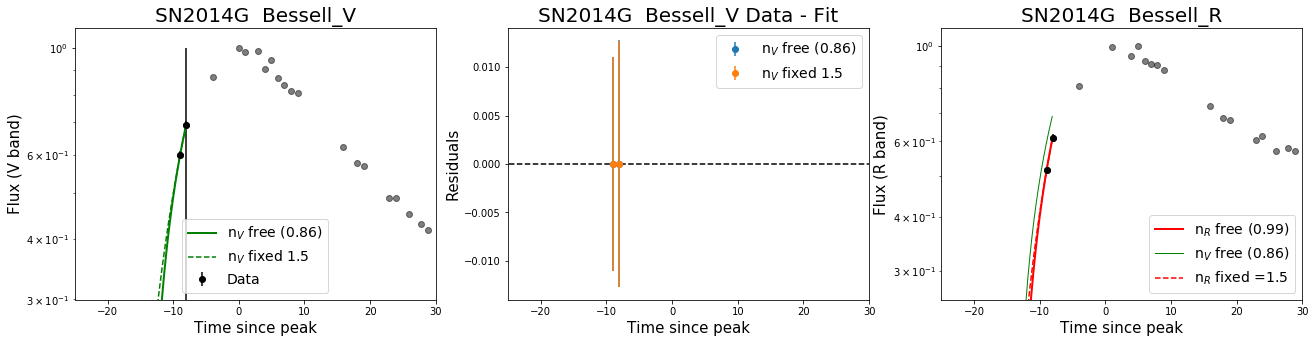

Looking for Photometry for SN2013ge in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2013ge.dat
Got it!
Photometry loaded


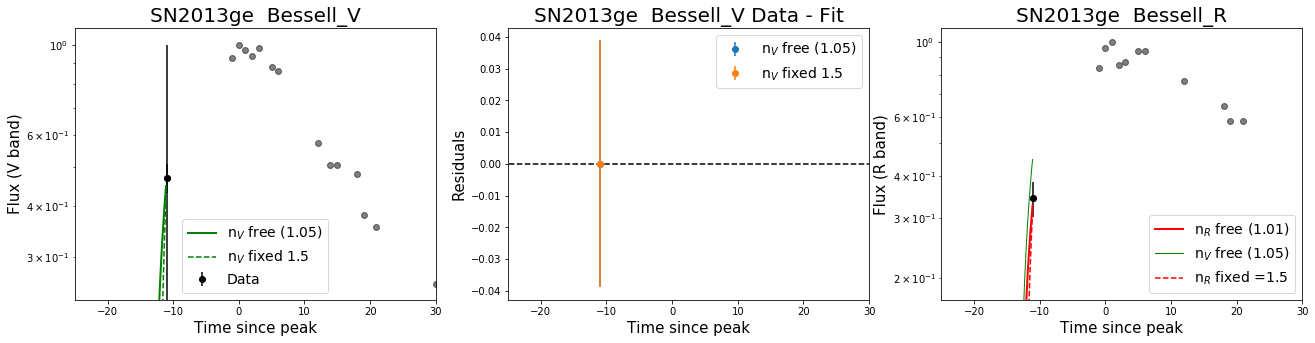

Looking for Photometry for SN2013fs in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2013fs.dat
Got it!
Photometry loaded


Looking for Photometry for SN2013ej in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2013ej.dat
Got it!
Photometry loaded


Looking for Photometry for SN2013df in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2013df.dat
Got it!
Photometry loaded


ValueError: max() arg is an empty sequence

In [281]:
for sn in sn_list[::-1]:

    SN = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname=sn, verbose=True)
    SN.load()
    SN.get_availfilter()
    SN.clip_photometry()
    fig = plt.figure(figsize=(22,5))
    plt.subplot(131)
    
    band= 'Bessell_V' if sn!='SN2008aq' else 'swift_V'
    flux_full = SN.clipped_phot[SN.clipped_phot['filter']==band]['flux']
    fluxerr_full = SN.clipped_phot[SN.clipped_phot['filter']==band]['flux_err']
    t_full = SN.clipped_phot[SN.clipped_phot['filter']==band]['MJD']
    phase_full = t_full-t_full[np.argmax(flux_full)]
    peak_V = t_full[np.argmax(flux_full)]
    plt.plot(phase_full, flux_full/max(flux_full), 'ok', alpha=0.5)
    
    # Half flux use data point with -- Flux_max < 0.5*Flux_max --
    half_max_flux = 0.75*max(flux_full)
    if len(flux_full[phase_full<0]<half_max_flux)>=1:
        max_v_phase = max(phase_full[phase_full<0][flux_full[phase_full<0]<half_max_flux])
    else:
        max_v_phase=0.
        
    phase_prova = phase_full[phase_full<=max_v_phase]
    flux_prova = flux_full[phase_full<=max_v_phase]/max(flux_full)
    fluxerr_prova = fluxerr_full[phase_full<=max_v_phase]/max(flux_full)
    plt.xlim(min(min(phase_prova)-5., -25.),30)
    plt.vlines(max_v_phase, 0,1)
    
    def func(x, a, t0, n):
        f_t = np.zeros(len(x))
        f_t[x>t0] = a * (x[x>t0]-t0)**n
        return f_t
    
    plt.errorbar(phase_prova, flux_prova, yerr=fluxerr_prova, 
                 fmt='ok', label='Data')
    plt.ylabel('Flux (V band)', fontsize=15)
    t_extr = np.arange(min(min(phase_prova)-5., -30.), max(phase_prova),0.1)
    p0 = [0.5, min(min(phase_prova),-15.), 1.5]
    #plt.plot(t_extr, func(t_extr, p0[0], p0[1], p0[2]), 'r--')
    
    res_V_nfree = opt.curve_fit(func, phase_prova, flux_prova, p0=p0, 
                        sigma=fluxerr_prova, maxfev=10000, bounds=([0., -100.,0.1],[10.,0.,10.]))
    plt.subplot(132)
    plt.errorbar(phase_prova, flux_prova-func(phase_prova, res_V_nfree[0][0], res_V_nfree[0][1], res_V_nfree[0][2]),
             yerr=fluxerr_prova,
            fmt='o', label=r'n$_{V}$ free (%.2f)'%res_V_nfree[0][2])

    plt.xlim(min(min(phase_prova)-5., -25.),30)

    plt.subplot(131)
    plt.plot(t_extr, func(t_extr, res_V_nfree[0][0], res_V_nfree[0][1], res_V_nfree[0][2]), 'g',lw=2,
            label=r'n$_{V}$ free (%.2f)'%res_V_nfree[0][2])
    
    def func(x, a, t0):
        f_t = np.zeros(len(x))
        f_t[x>t0] = a * (x[x>t0]-t0)**1.5
        return f_t
    
    res_V_nfix = opt.curve_fit(func, phase_prova, flux_prova, p0=p0[:2], 
                        sigma=fluxerr_prova, maxfev=10000,  bounds=([0., -100.],[10.,0.]))
    plt.plot(t_extr, func(t_extr, res_V_nfix[0][0], res_V_nfix[0][1]), '--g',
            label=r'n$_{V}$ fixed 1.5')
    plt.yscale('log')
    plt.ylim(min(flux_prova)*0.5,1.1)
    plt.title(sn+'  '+band, fontsize=20)
    plt.legend(fontsize=14)
    plt.xlabel('Time since peak', fontsize=15)
    
    plt.subplot(132)
    plt.title(sn+'  '+band+' Data - Fit', fontsize=20)
    plt.ylabel('Residuals', fontsize=15)

    plt.errorbar(phase_prova, flux_prova-func(phase_prova, res_V_nfix[0][0], res_V_nfix[0][1]), yerr=fluxerr_prova,
             fmt='o', label=r'n$_{V}$ fixed 1.5')
    plt.xlim(min(min(phase_prova)-5., -25.),30)
    plt.legend(fontsize=14)
    plt.xlabel('Time since peak', fontsize=15)
    plt.hlines(0, -100,100, linestyle='--')
    
    
    plt.subplot(133)
    if ('Bessell_R' in np.unique(SN.clipped_phot['filter'])):
        band = 'Bessell_R'
    elif ('sdss_r' in np.unique(SN.clipped_phot['filter'])):
        band = 'sdss_r'
    elif ("sdss_r'" in np.unique(SN.clipped_phot['filter'])):
        band = "sdss_r'"

    try:
        flux_full = SN.clipped_phot[SN.clipped_phot['filter']==band]['flux']
        fluxerr_full = SN.clipped_phot[SN.clipped_phot['filter']==band]['flux_err']
        t_full = SN.clipped_phot[SN.clipped_phot['filter']==band]['MJD']
        phase_full = t_full-peak_V
        
        plt.plot(phase_full, flux_full/max(flux_full), 'ok', alpha=0.5)
        plt.xlim(min(min(phase_prova)-5., -25.),30)
        
        flux_prova = flux_full[phase_full<=max_v_phase]/max(flux_full)
        fluxerr_prova = fluxerr_full[phase_full<=max_v_phase]/max(flux_full)
        phase_prova = phase_full[phase_full<=max_v_phase]
        
        def func(x, a, t0, n):
            f_t = np.zeros(len(x))
            f_t[x>t0] = a * (x[x>t0]-t0)**n
            return f_t
    
        plt.errorbar(phase_prova, flux_prova, yerr=fluxerr_prova, fmt='ok')
        
        #t_extr = np.arange(-30., max(phase_prova),0.1)
        #p0 = [0.1, min(min(phase_prova),-15.), 1.5]
        #plt.plot(t_extr, func(t_extr, p0[0], p0[1], p0[2]), 'r--')
        
        res = opt.curve_fit(func, phase_prova, flux_prova, p0=p0, 
                            sigma=fluxerr_prova, maxfev=10000, bounds=([0., -100.,0.1],[10.,0.,10.]))
        plt.plot(t_extr, func(t_extr, res[0][0], res[0][1], res[0][2]), 'r',lw=2,
                label=r'n$_{R}$ free (%.2f)'%res[0][2])
        plt.plot(t_extr, func(t_extr, res_V_nfree[0][0], res_V_nfree[0][1], res_V_nfree[0][2]),
            label=r'n$_{V}$ free (%.2f)'%res_V_nfree[0][2], linestyle='-',lw=1, color='g')

        def func(x, a, t0):
            f_t = np.zeros(len(x))
            f_t[x>t0] = a * (x[x>t0]-t0)**1.5
            return f_t
        
        res = opt.curve_fit(func, phase_prova, flux_prova, p0=p0[:2], 
                            sigma=fluxerr_prova, maxfev=10000,  bounds=([0., -100.],[10.,0.]))
        plt.plot(t_extr, func(t_extr, res[0][0], res[0][1]), '--r',
                label=r'n$_{R}$ fixed =1.5')
        plt.yscale('log')
        plt.ylim(min(flux_prova)*0.5,1.1)
        plt.title(sn+'  '+band, fontsize=20)
        plt.legend(fontsize=14)
        plt.xlabel('Time since peak', fontsize=15)
        plt.ylabel('Flux (R band)', fontsize=15)

    except Exception as e:
        print (e)
        
    plt.show()
    plt.close(fig)

In [ ]:
explosion_dates = {'SN2013ge': (56602.5,1.5),
                  'SN2013ej':(56497.5, None)}

In [35]:
t = np.arange(0.5,2.,0.01)
texp = 0.5

0.960264500792218
0.9221079114817278
0.8164965809277261
0.6666666666666666
0.5443310539518174
0.4444444444444444


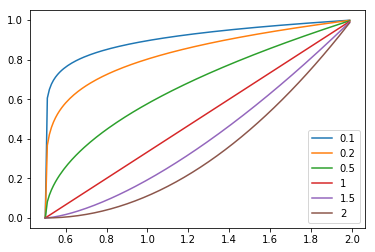

In [52]:
for n in [0.1,0.2,0.5,1,1.5,2]:
    plt.plot(t, ((t-texp)**(n))/((2.-texp)**(n)), label=n)
    print (1./((2.-texp)**(n)))
plt.legend()

In [37]:
for n in [0.1,0.2, 0.5, 1., 1.5, 2]:#,0.5,1,1.5,2]:
    plt.plot(t, ((t-texp)**(n)), label=n)
    
plt.legend()

In [54]:
for n in [0.1,0.2, 0.5, 1., 1.5, 2]:#,0.5,1,1.5,2]:
    plt.plot(t, ((t-texp)**(n))/((0.05)**(n)), label=n)
plt.legend()
plt.xlim(0.4,1.1)
plt.ylim(-2,10.)

(-2, 10.0)

In [107]:
x=np.arange(-1,10.,0.1)

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


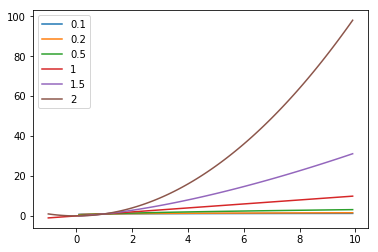

In [108]:
for n in [0.1,0.2,0.5,1,1.5,2]:
    plt.plot(x, (x**n), label=n)
plt.legend()